In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt

In [2]:
class LandmarkDataset(Dataset):
    def __init__(self, directory):
        self.directory = directory
        self.files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.directory, self.files[idx])
        data = np.loadtxt(file_path)
        return torch.tensor(data, dtype=torch.float32)

human_dataset = LandmarkDataset("/content/human_landmarks")
manga_dataset = LandmarkDataset("/content/manga_landmarks")

human_dataloader = DataLoader(human_dataset, batch_size=11, shuffle=True)
manga_dataloader = DataLoader(manga_dataset, batch_size=11, shuffle=True)

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(34, 136),
            nn.ReLU(),
            nn.Linear(136, 272),
            nn.ReLU(),
            nn.Linear(272, 136),
            nn.ReLU(),
            nn.Linear(136, 34)
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(34, 136),
            nn.ReLU(),
            nn.Linear(136, 68),
            nn.ReLU(),
            nn.Linear(68, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [4]:
G_H2M = Generator()
G_M2H = Generator()
D_H = Discriminator()
D_M = Discriminator()

In [5]:
# Define loss function and optimizers
criterion_GAN = nn.BCELoss()
criterion_cycle = nn.L1Loss()
lr = 0.0002

optimizer_G_H2M = optim.Adam(G_H2M.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_G_M2H = optim.Adam(G_M2H.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_H = optim.Adam(D_H.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_M = optim.Adam(D_M.parameters(), lr=lr, betas=(0.5, 0.999))

# Labels for real and fake data
real_label = torch.ones((11, 1))
fake_label = torch.zeros((11, 1))

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    for (human_landmarks, manga_landmarks) in zip(human_dataloader, manga_dataloader):
        # Move data to GPU if available
        human_landmarks = human_landmarks
        manga_landmarks = manga_landmarks

        # Train Generators
        optimizer_G_H2M.zero_grad()
        optimizer_G_M2H.zero_grad()

        # GAN loss
        fake_manga = G_H2M(human_landmarks)
        pred_fake = D_M(fake_manga)
        loss_GAN_H2M = criterion_GAN(pred_fake, real_label)

        fake_human = G_M2H(manga_landmarks)
        pred_fake = D_H(fake_human)
        loss_GAN_M2H = criterion_GAN(pred_fake, real_label)

        # Cycle consistency loss
        recovered_human = G_M2H(fake_manga)
        loss_cycle_H2M = criterion_cycle(recovered_human, human_landmarks)

        recovered_manga = G_H2M(fake_human)
        loss_cycle_M2H = criterion_cycle(recovered_manga, manga_landmarks)

        # Total generator loss
        loss_G = loss_GAN_H2M + loss_GAN_M2H + 10.0 * (loss_cycle_H2M + loss_cycle_M2H)
        loss_G.backward()

        optimizer_G_H2M.step()
        optimizer_G_M2H.step()

        # Train Discriminator H
        optimizer_D_H.zero_grad()

        # Real loss
        pred_real = D_H(human_landmarks)
        loss_D_real = criterion_GAN(pred_real, real_label)

        # Fake loss
        pred_fake = D_H(fake_human.detach())
        loss_D_fake = criterion_GAN(pred_fake, fake_label)

        # Total loss
        loss_D_H = (loss_D_real + loss_D_fake) * 0.5
        loss_D_H.backward()
        optimizer_D_H.step()

        # Train Discriminator M
        optimizer_D_M.zero_grad()

        # Real loss
        pred_real = D_M(manga_landmarks)
        loss_D_real = criterion_GAN(pred_real, real_label)

        # Fake loss
        pred_fake = D_M(fake_manga.detach())
        loss_D_fake = criterion_GAN(pred_fake, fake_label)

        # Total loss
        loss_D_M = (loss_D_real + loss_D_fake) * 0.5
        loss_D_M.backward()
        optimizer_D_M.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] Loss G: {loss_G.item()} Loss D_H: {loss_D_H.item()} Loss D_M: {loss_D_M.item()}')

Epoch [1/500] Loss G: 13.066232681274414 Loss D_H: 0.672919750213623 Loss D_M: 0.6842808723449707
Epoch [2/500] Loss G: 12.554808616638184 Loss D_H: 0.6493532061576843 Loss D_M: 0.6599479913711548
Epoch [3/500] Loss G: 9.847528457641602 Loss D_H: 0.6426346302032471 Loss D_M: 0.6520884037017822
Epoch [4/500] Loss G: 4.851705074310303 Loss D_H: 0.6518110036849976 Loss D_M: 0.6651952862739563
Epoch [5/500] Loss G: 2.894155979156494 Loss D_H: 0.661050021648407 Loss D_M: 0.680418848991394
Epoch [6/500] Loss G: 2.0215744972229004 Loss D_H: 0.680059552192688 Loss D_M: 0.691749095916748
Epoch [7/500] Loss G: 1.7988219261169434 Loss D_H: 0.6892904043197632 Loss D_M: 0.6940725445747375
Epoch [8/500] Loss G: 1.7899457216262817 Loss D_H: 0.6946516633033752 Loss D_M: 0.6941729784011841
Epoch [9/500] Loss G: 1.8015077114105225 Loss D_H: 0.6940591335296631 Loss D_M: 0.69349205493927
Epoch [10/500] Loss G: 1.7664470672607422 Loss D_H: 0.6949905157089233 Loss D_M: 0.6934521198272705
Epoch [11/500] Loss

In [6]:
torch.save(G_H2M.state_dict(), 'G_H2M.pth')
torch.save(G_M2H.state_dict(), 'G_M2H.pth')
torch.save(D_H.state_dict(), 'D_H.pth')
torch.save(D_M.state_dict(), 'D_M.pth')

In [7]:
def plot_landmarks(landmarks):
    sorted_landmarks = landmarks[np.argsort(landmarks[:, 0])]
    x = sorted_landmarks[:, 0]
    y = sorted_landmarks[:, 1]

    pchip = PchipInterpolator(x, y)
    x_new = np.linspace(x.min(), x.max(), 100)
    y_new = pchip(x_new)

    plt.plot(x, y, 'o', label='Original')
    plt.plot(x_new, y_new, '-', label='PCHIP Interpolated')
    plt.legend()
    plt.show()

generated manga landmarks: tensor([[0.2176, 0.4903, 0.2296, 0.5483, 0.2404, 0.6237, 0.2582, 0.6946, 0.2853,
         0.7503, 0.3333, 0.8105, 0.3762, 0.8653, 0.4356, 0.9291, 0.5118, 0.9387,
         0.5910, 0.9251, 0.6513, 0.8707, 0.7077, 0.8126, 0.7740, 0.7626, 0.7877,
         0.6936, 0.8058, 0.6320, 0.8155, 0.5600, 0.8215, 0.4990]])


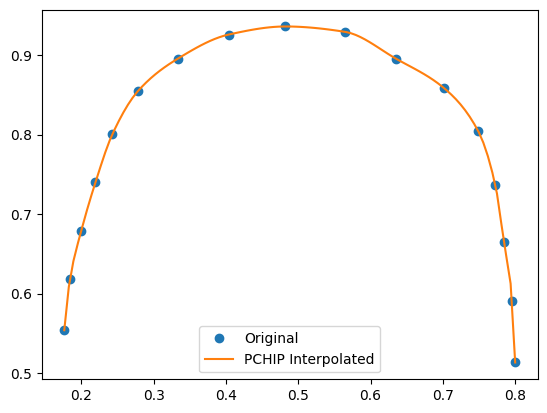

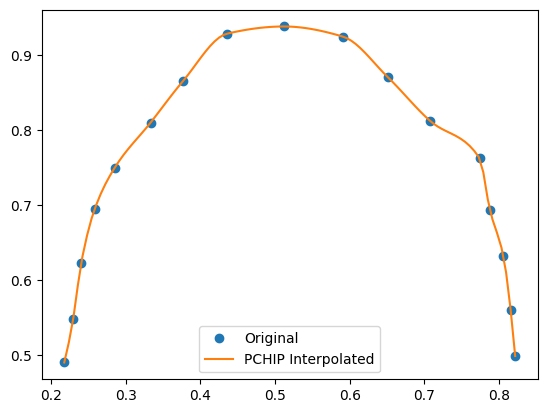

In [ ]:
test_human_dataset = LandmarkDataset("/content/test_landmarks")
test_human_dataloader = DataLoader(test_human_dataset, batch_size=1, shuffle=False)
G_H2M.load_state_dict(torch.load('G_H2M.pth'))
G_H2M.eval()
with torch.no_grad():
    for human_landmarks in test_human_dataloader:
        generated_manga_landmarks = G_H2M(human_landmarks)
        print("generated manga landmarks:", generated_manga_landmarks)
        plot_landmarks(human_landmarks.numpy().reshape(17, 2))
        plot_landmarks(generated_manga_landmarks.numpy().reshape(17, 2))

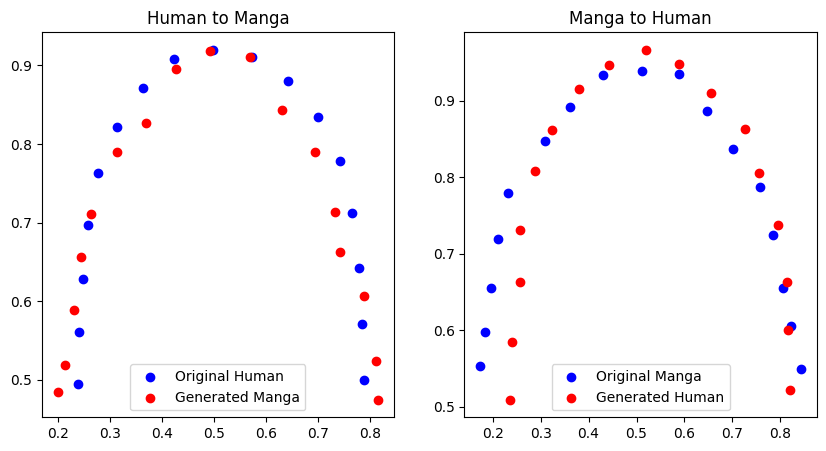

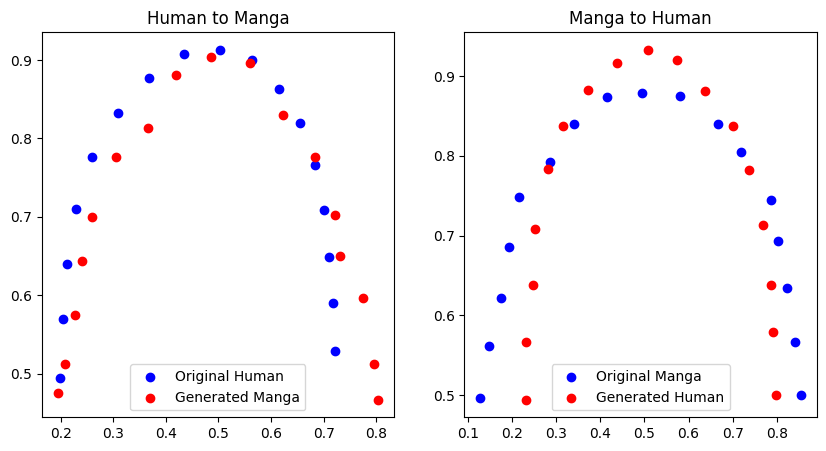

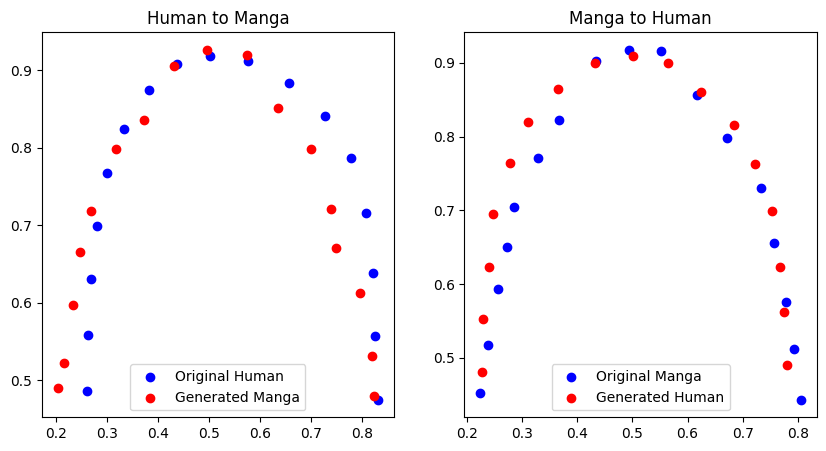

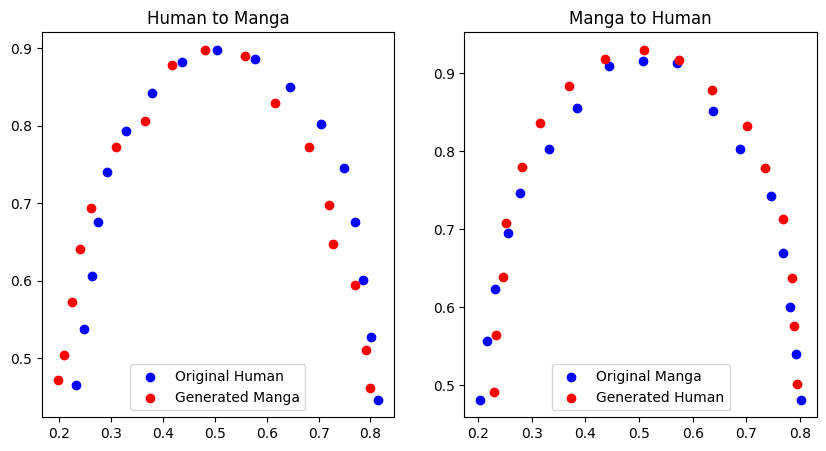

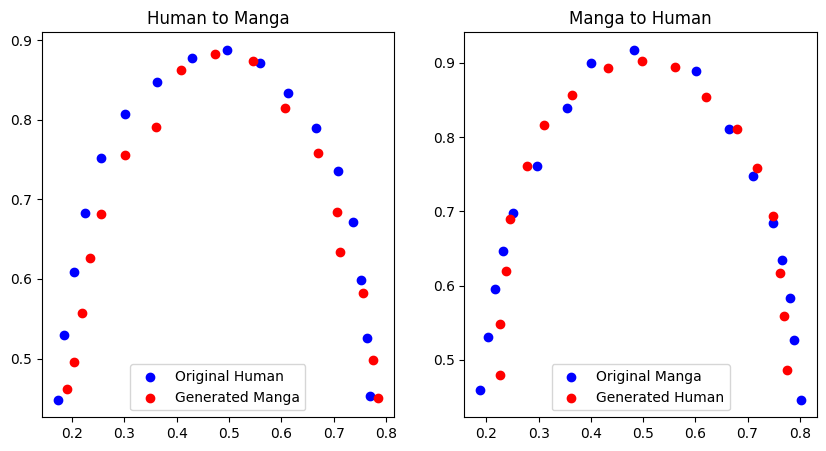

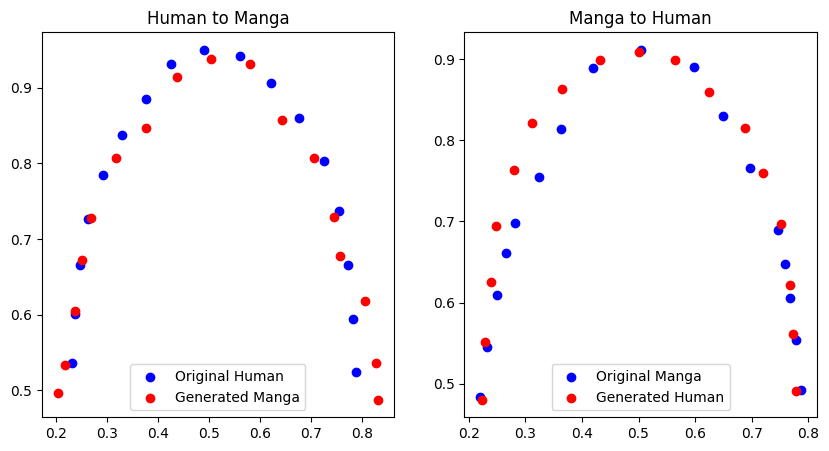

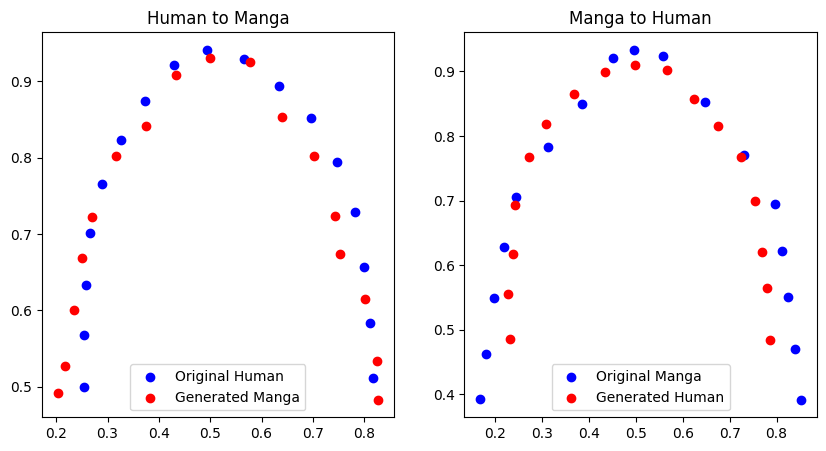

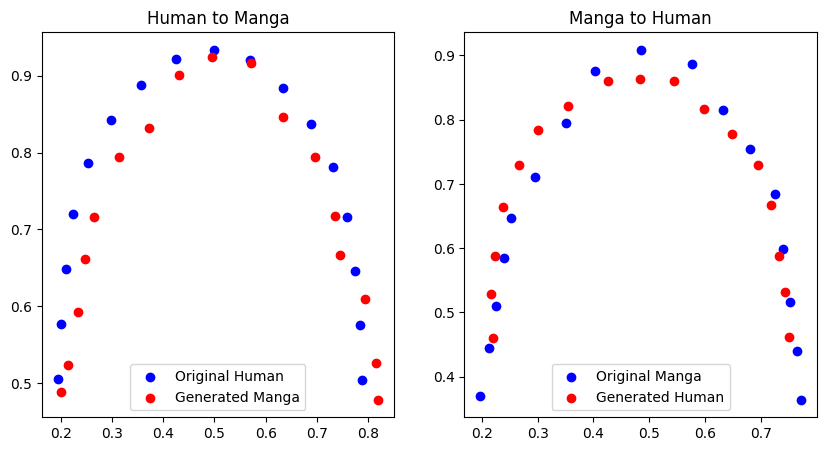

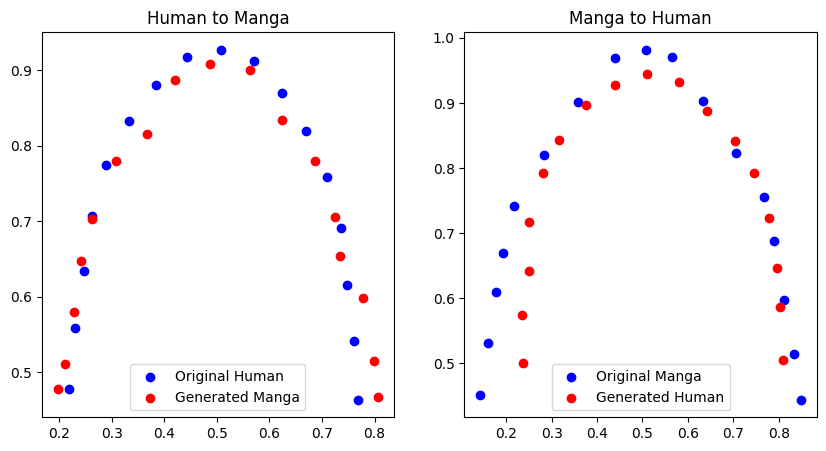

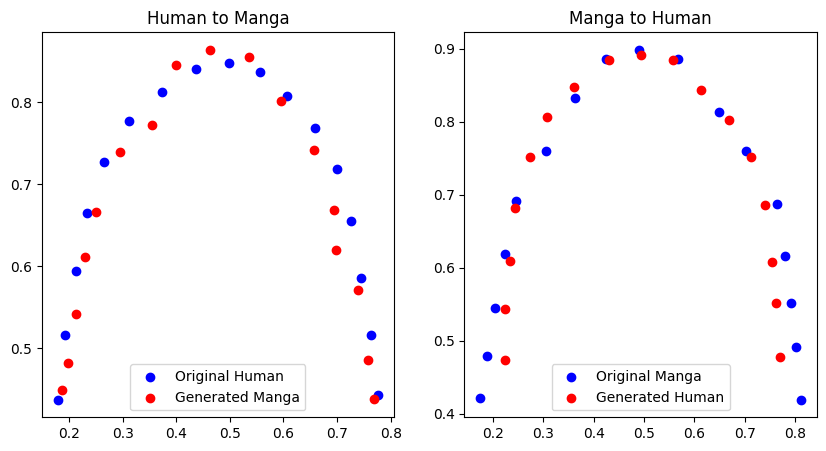

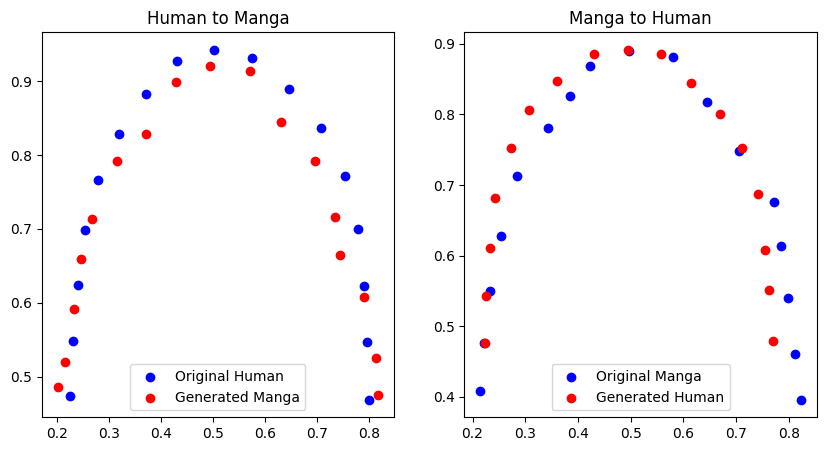

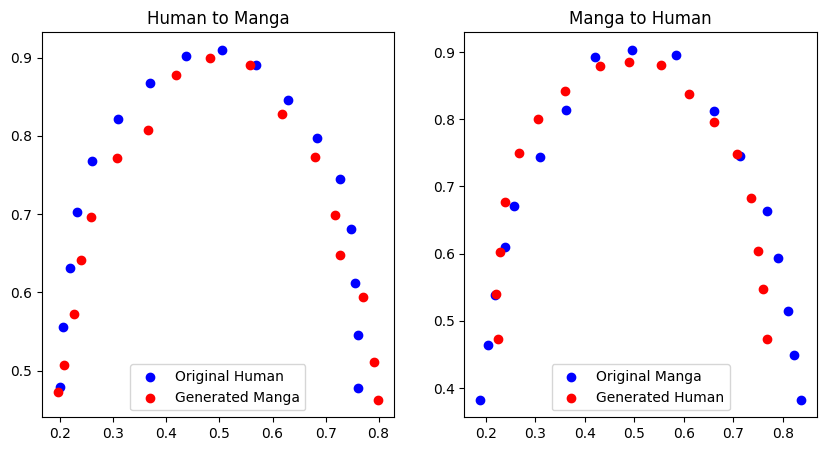

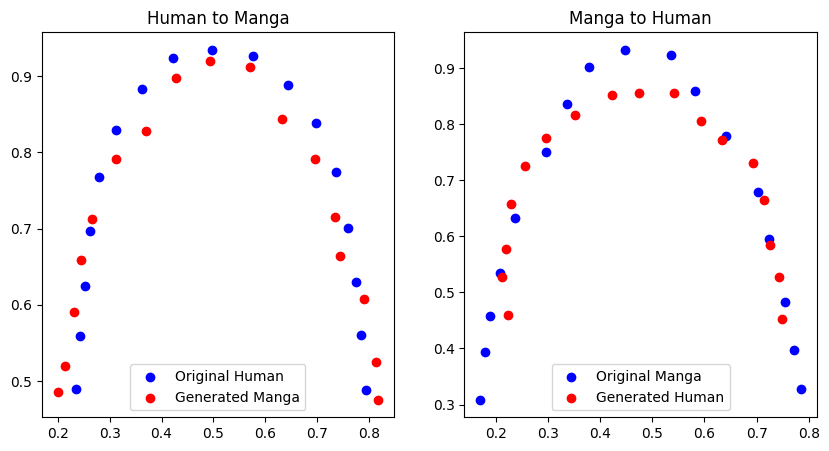

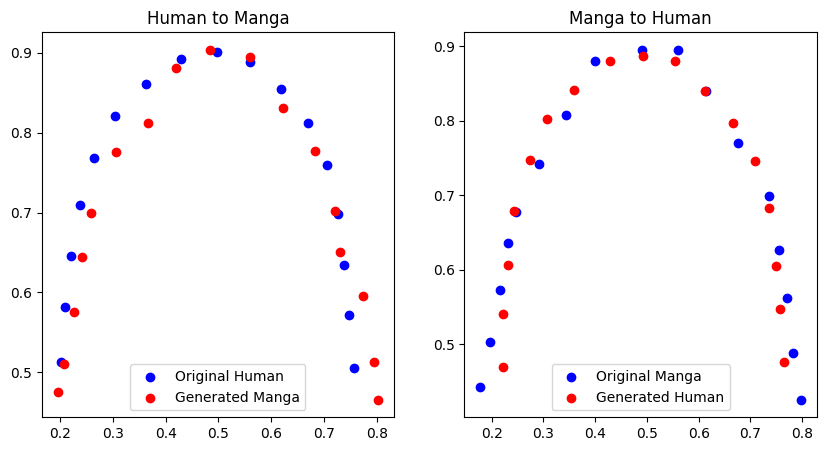

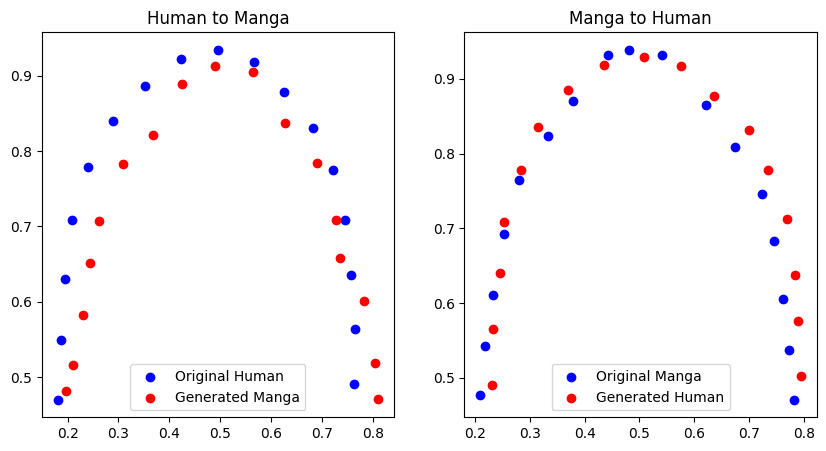

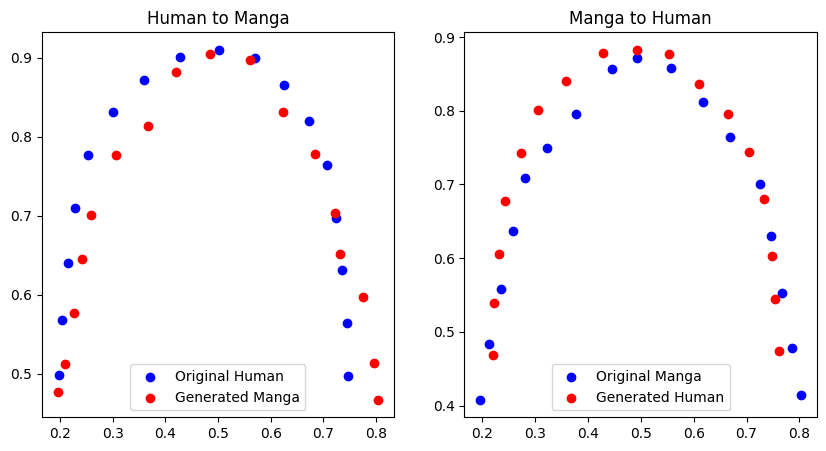

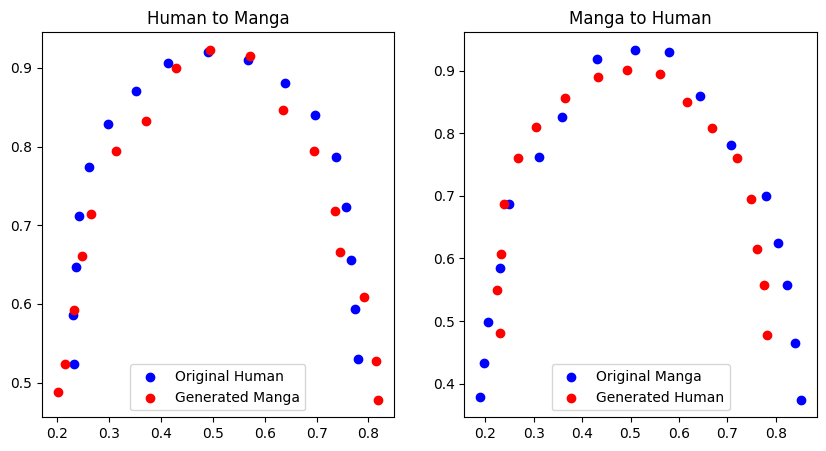

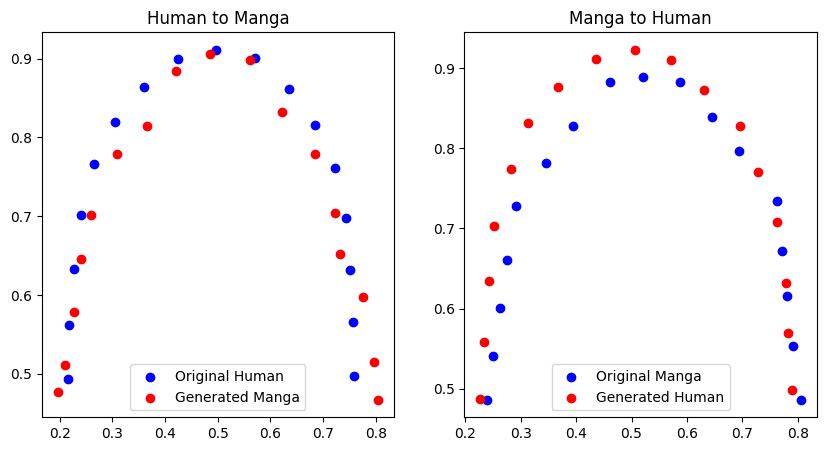

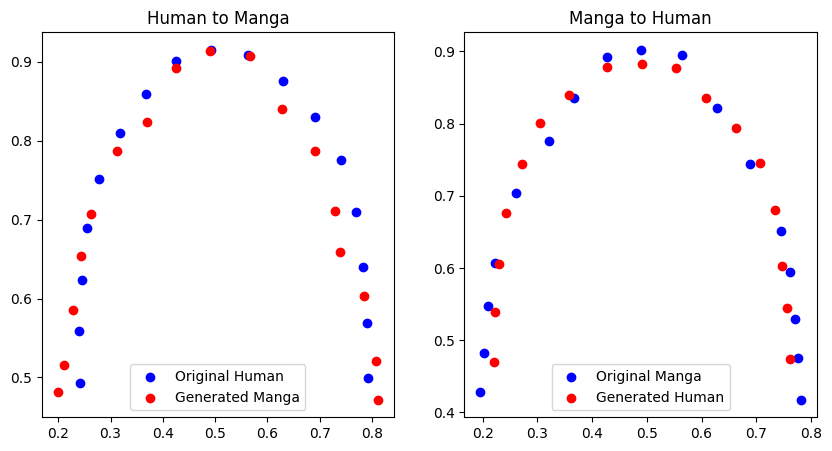

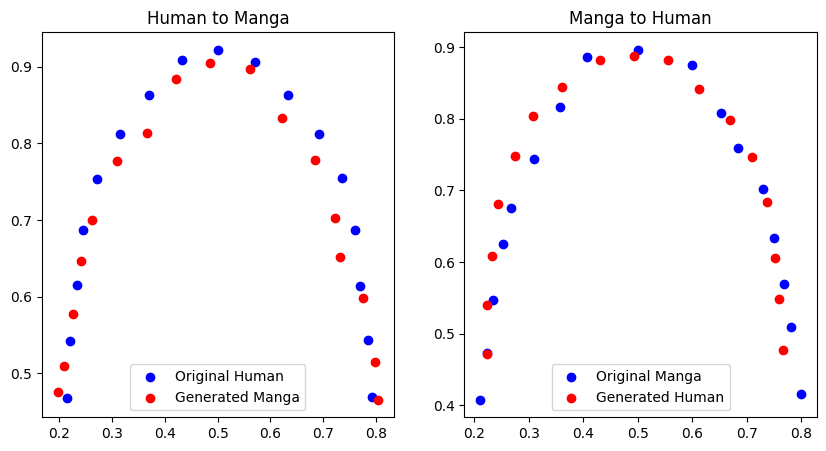

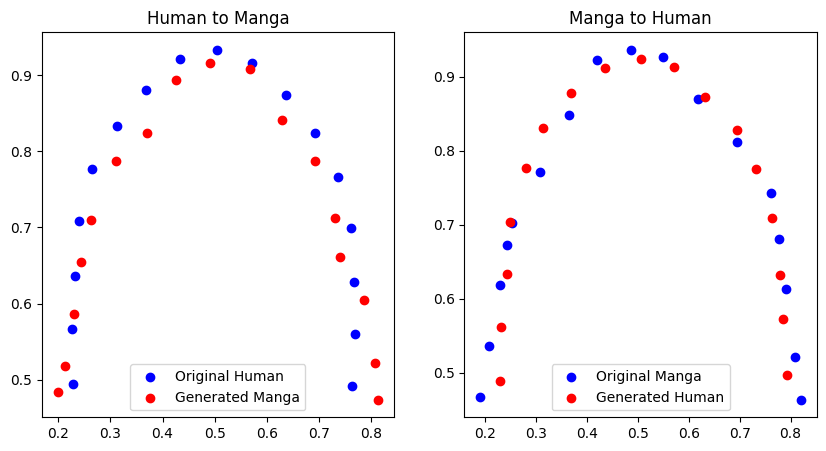

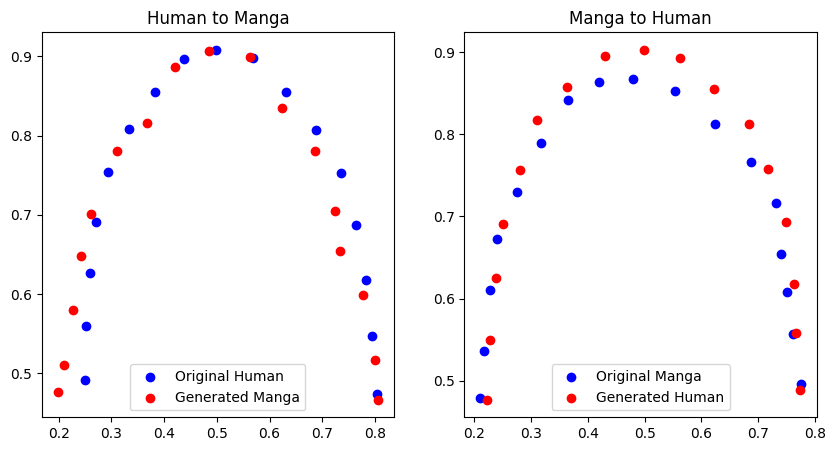

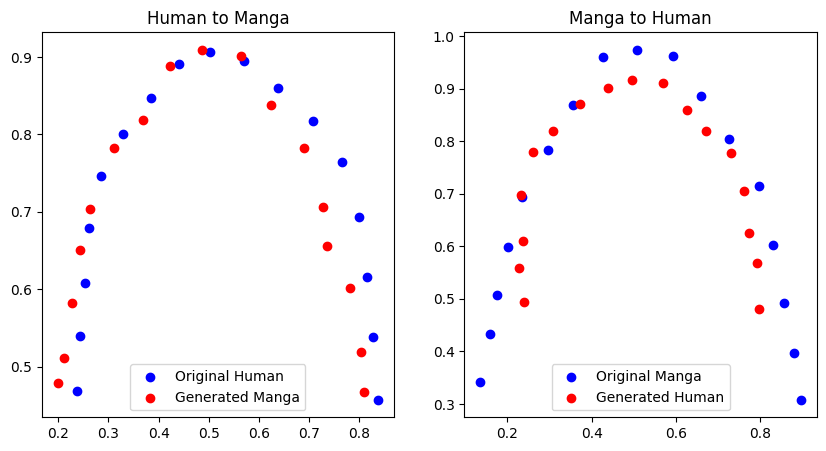

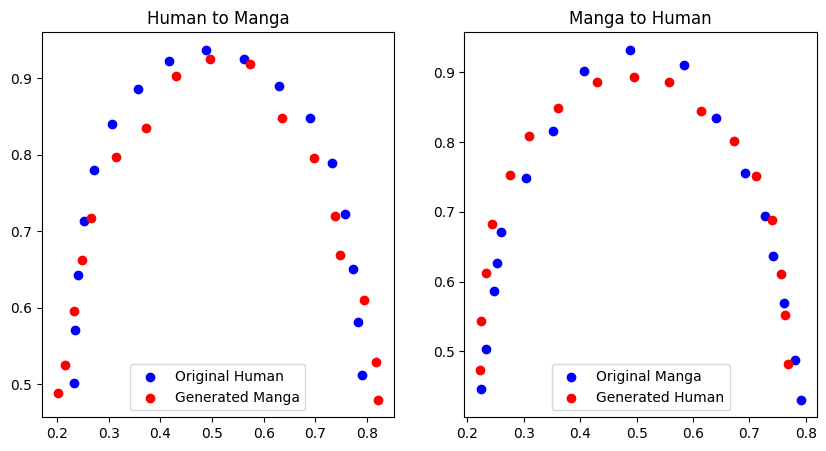

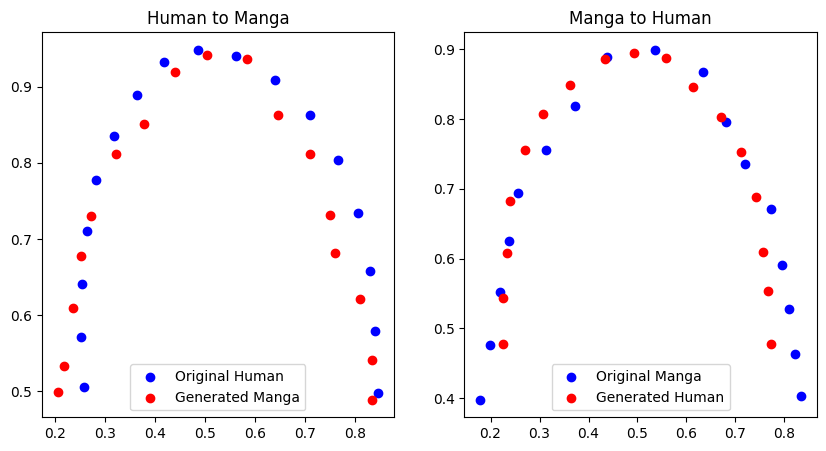

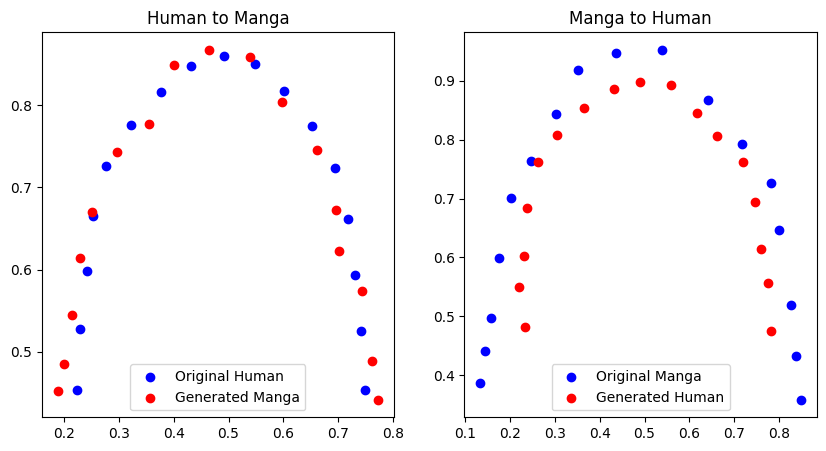

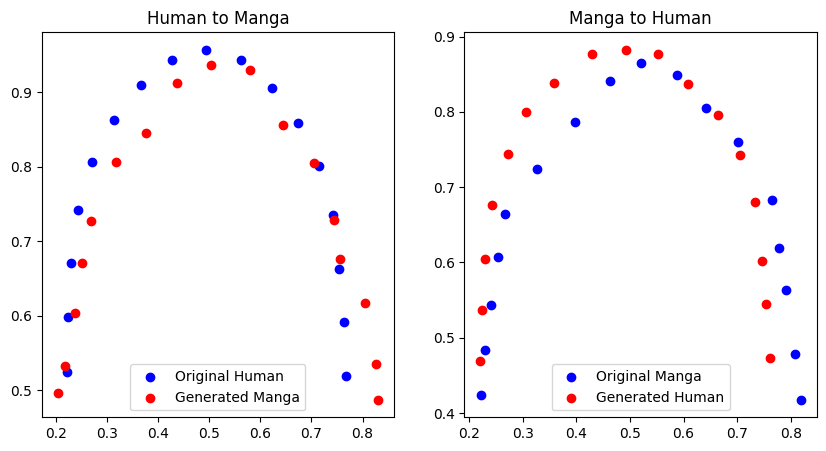

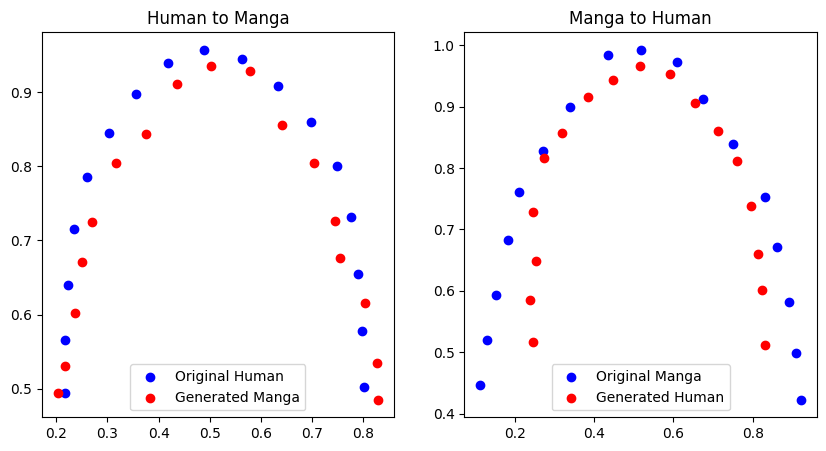

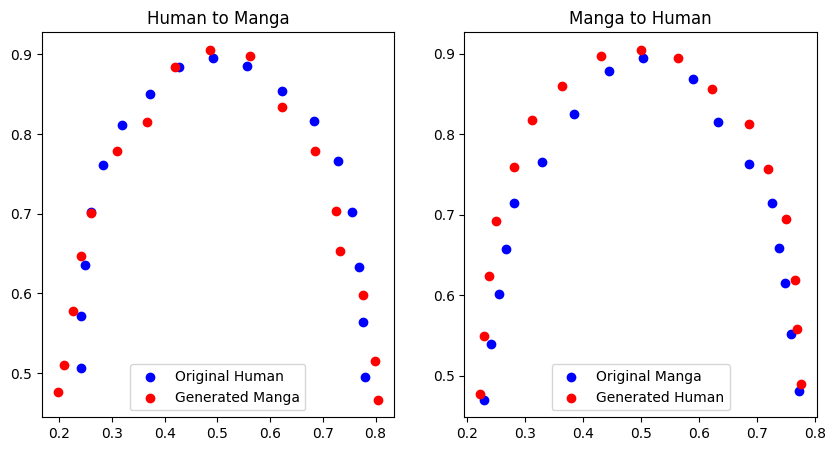

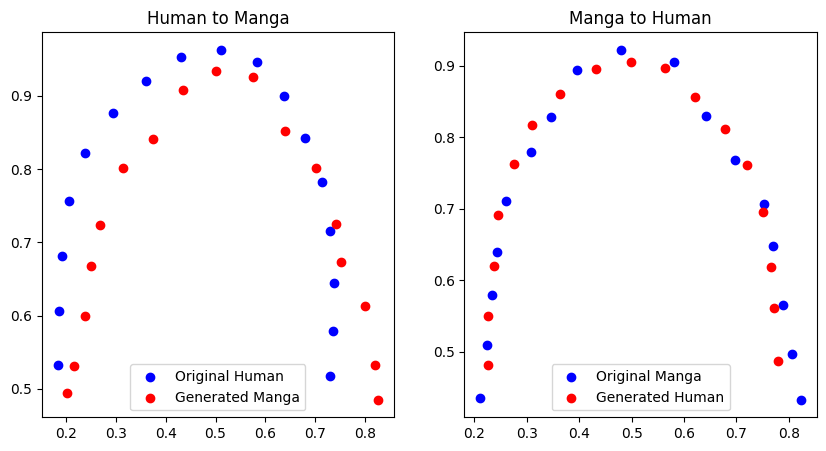

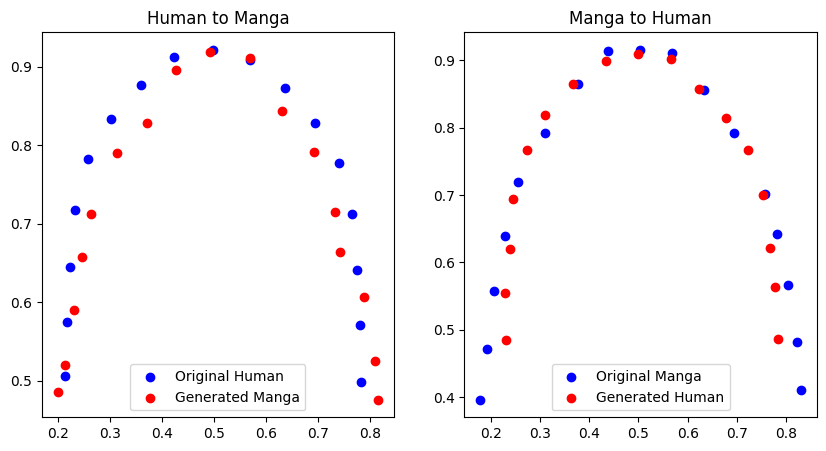

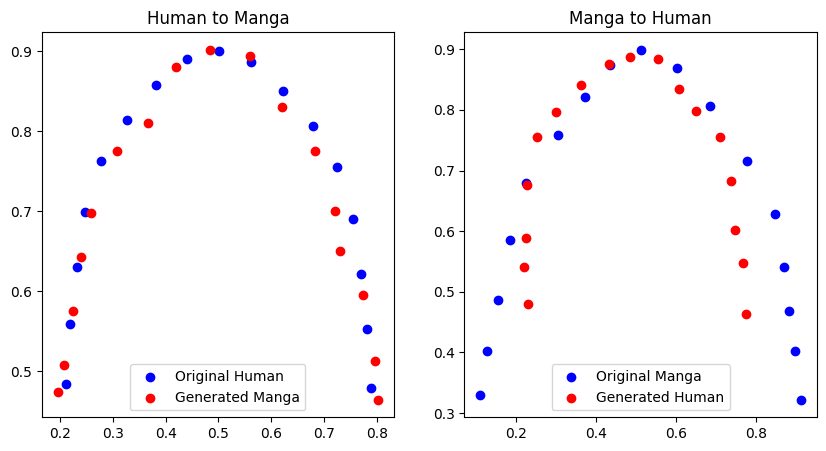

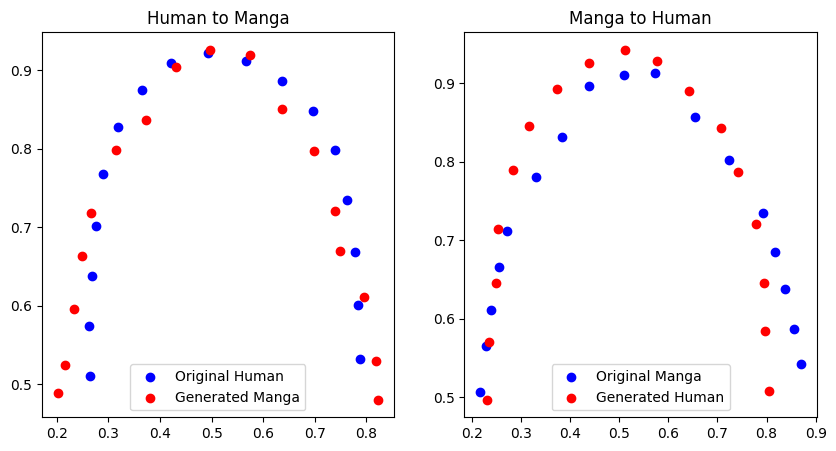

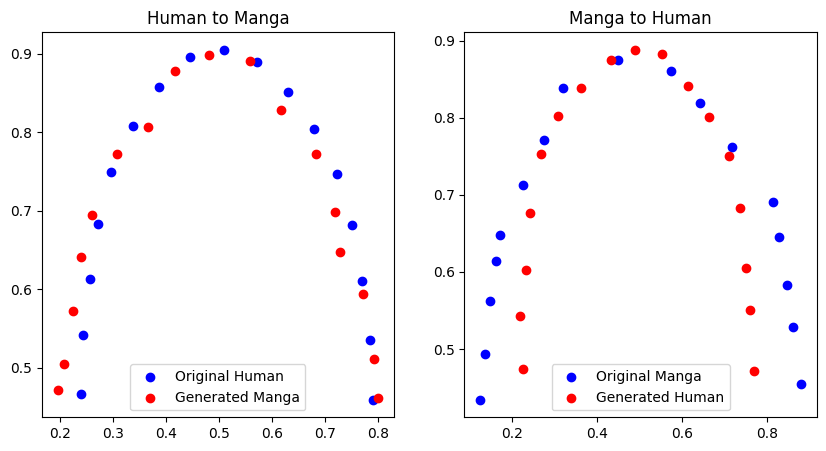

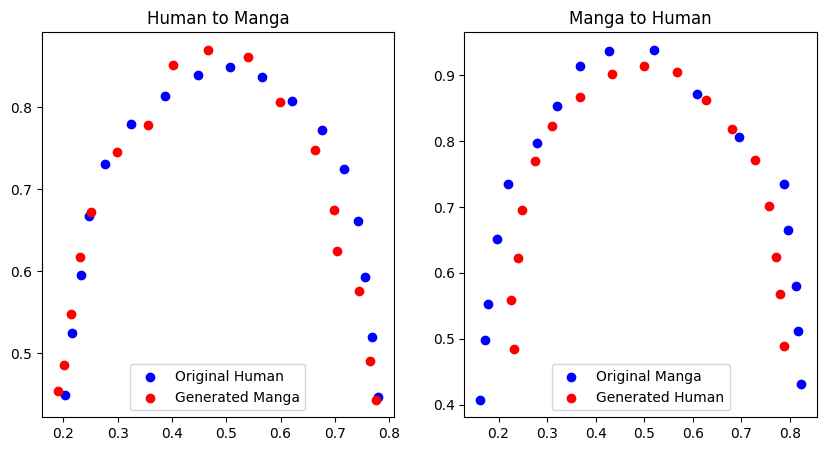

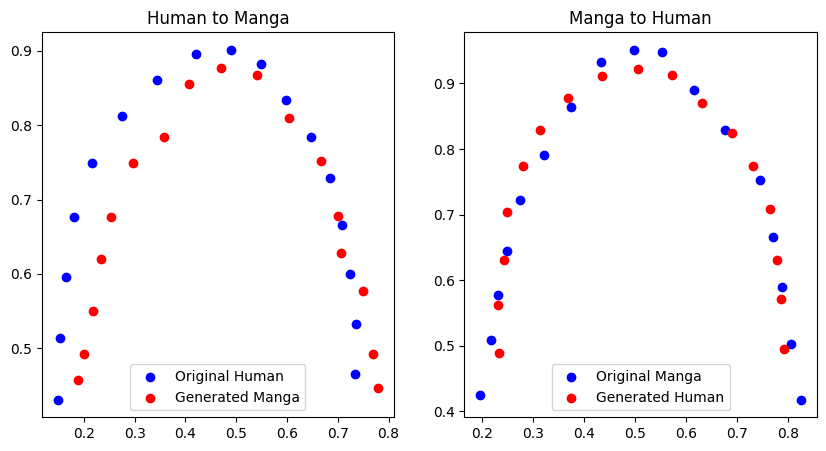

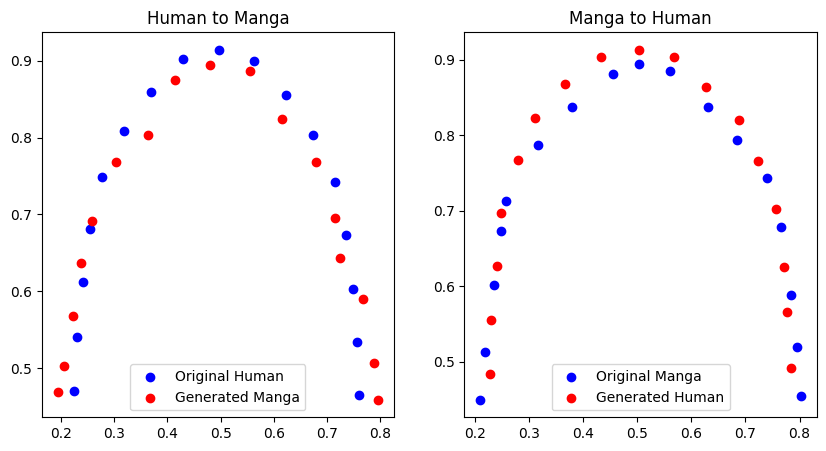

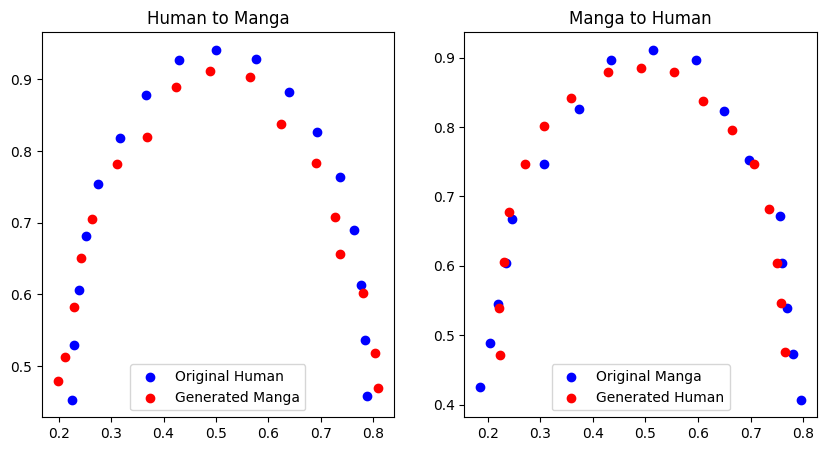

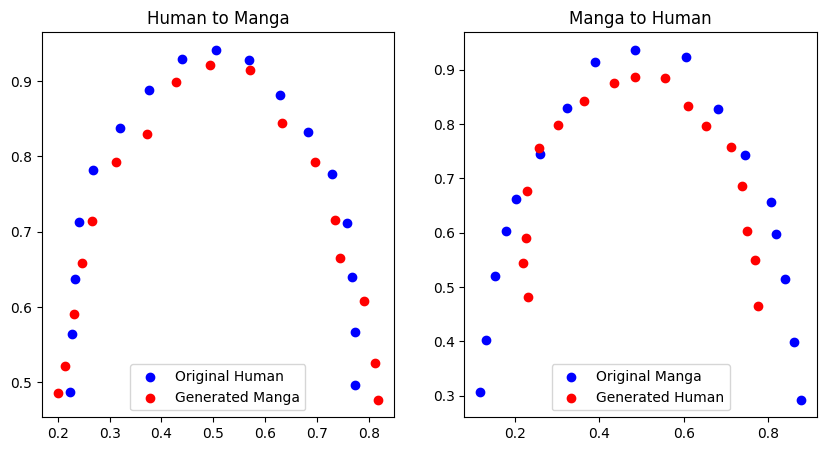

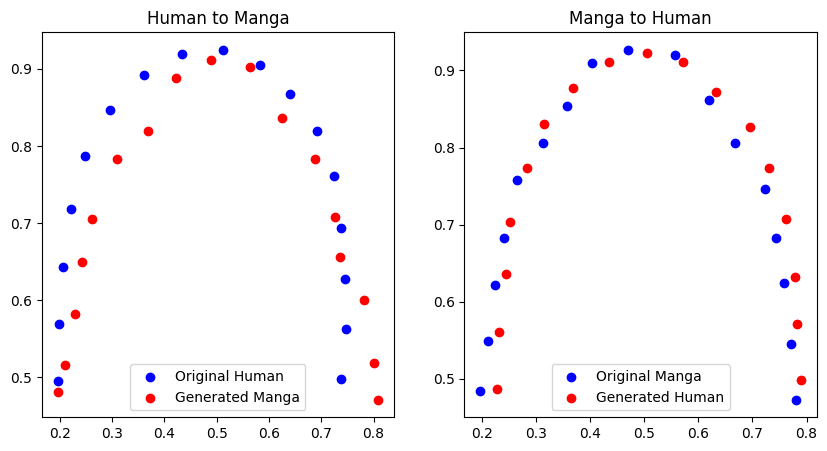

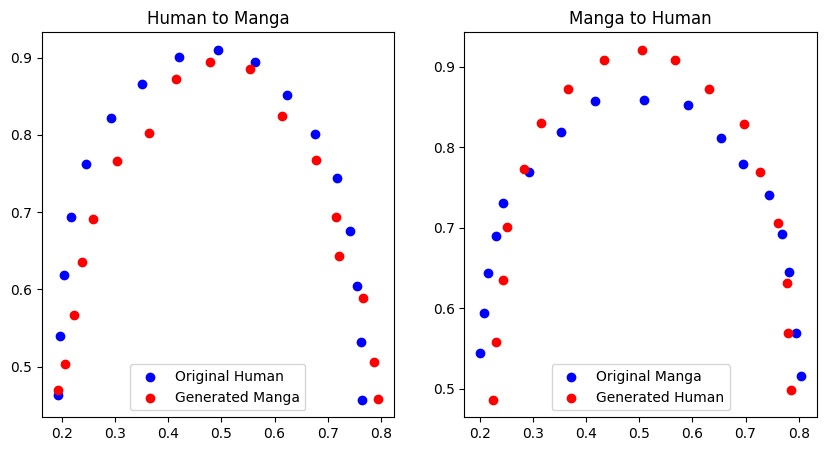

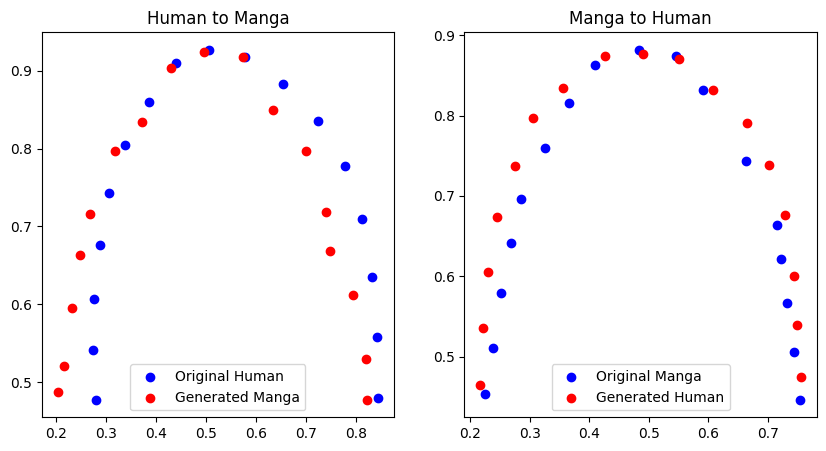

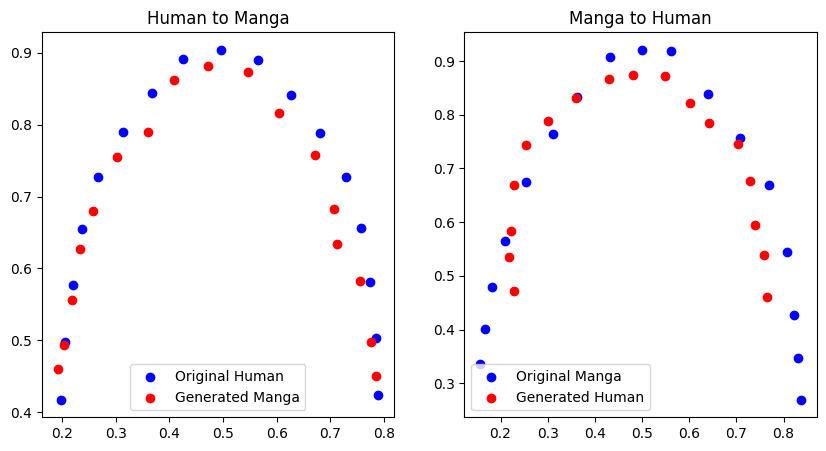

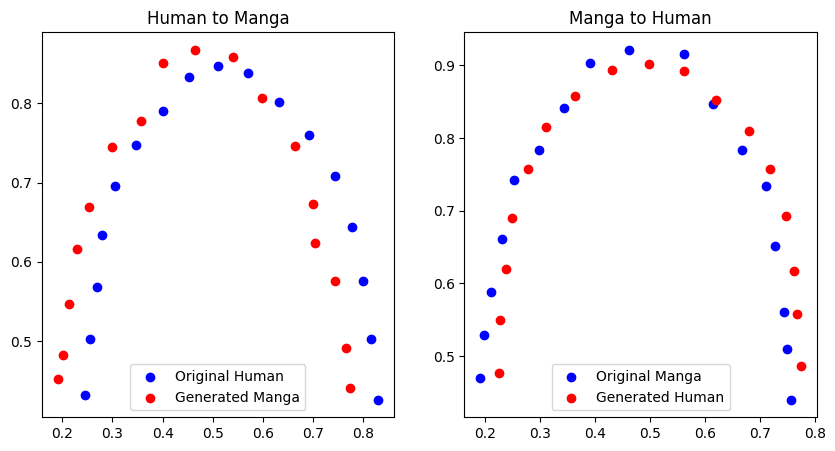

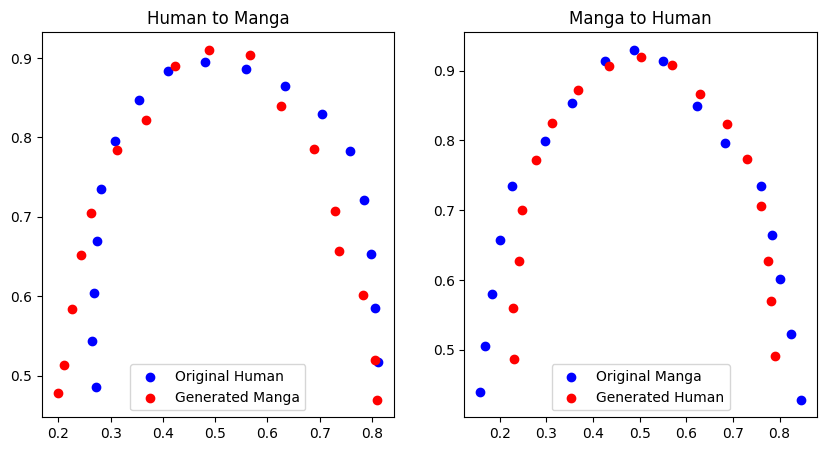

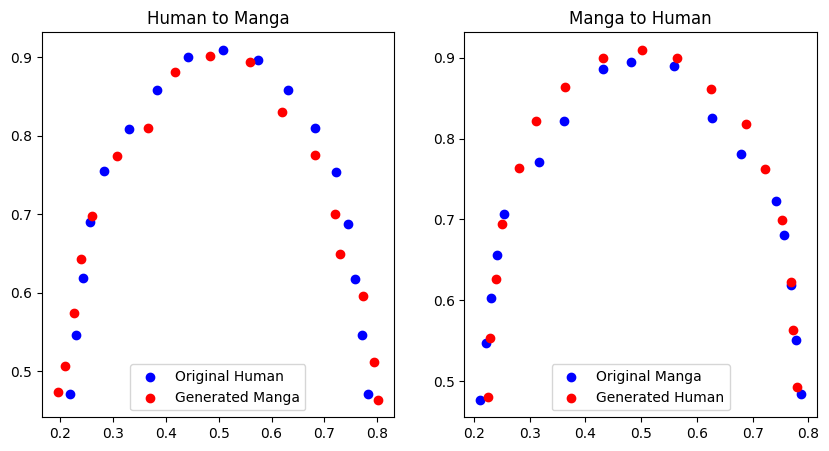

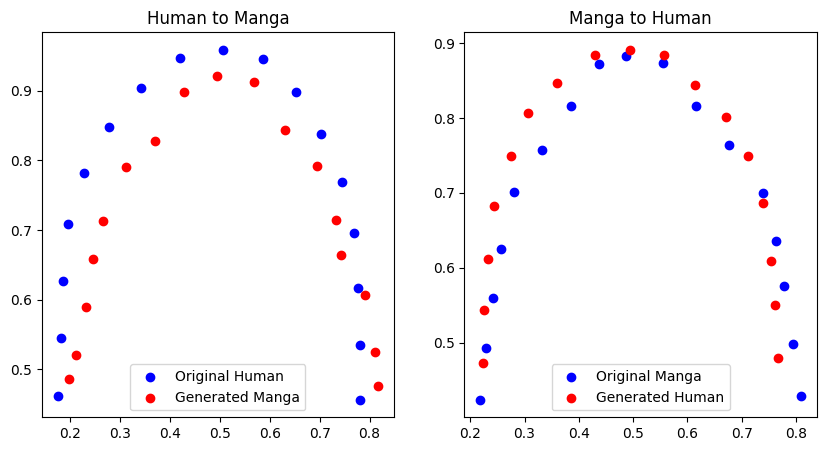

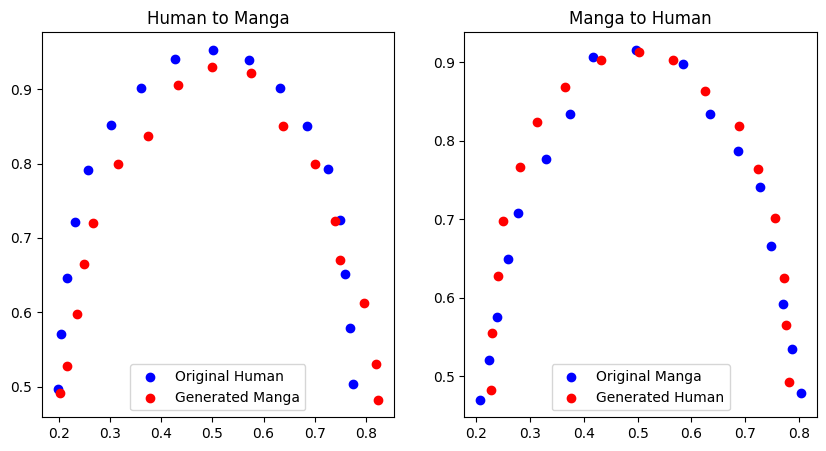

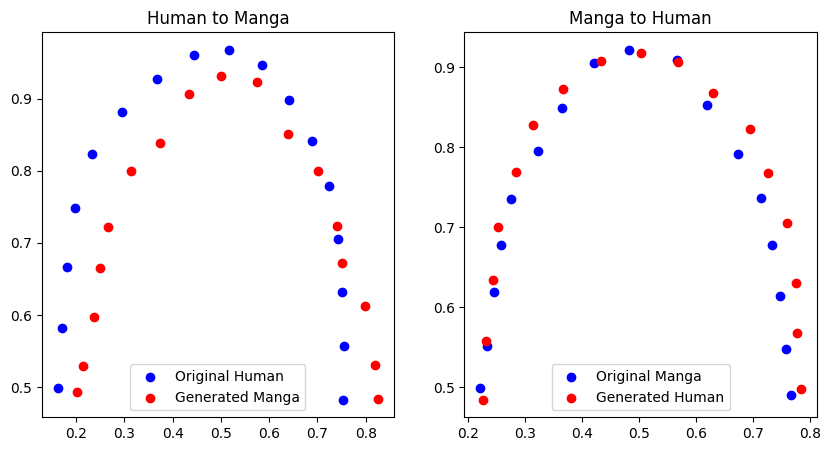

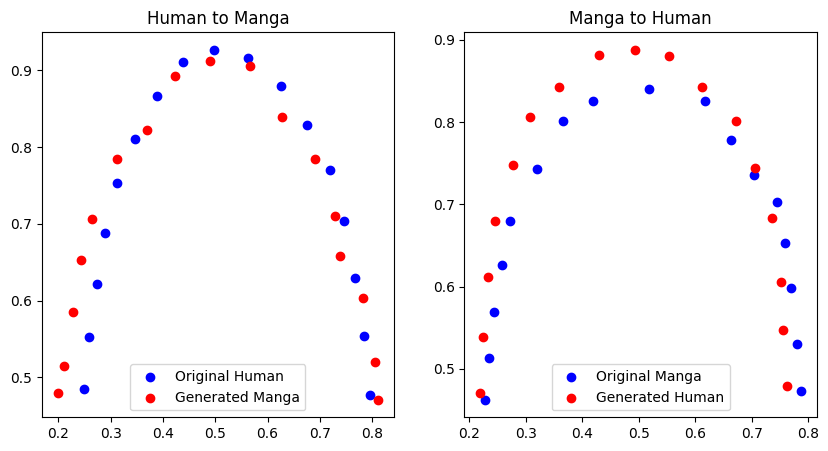

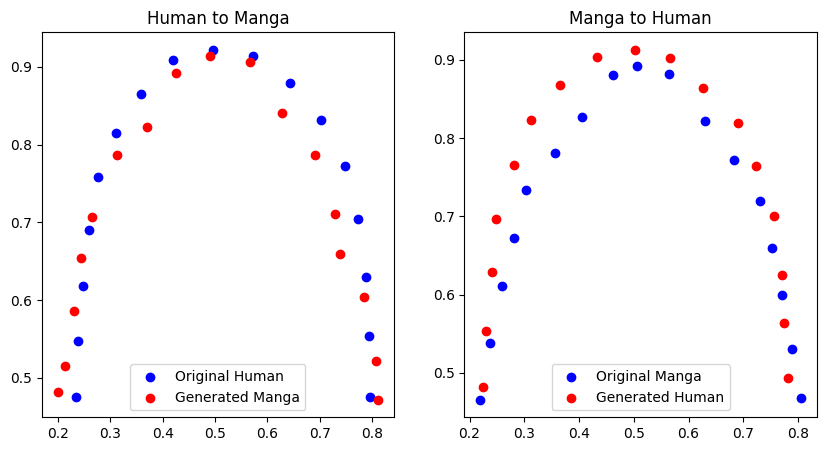

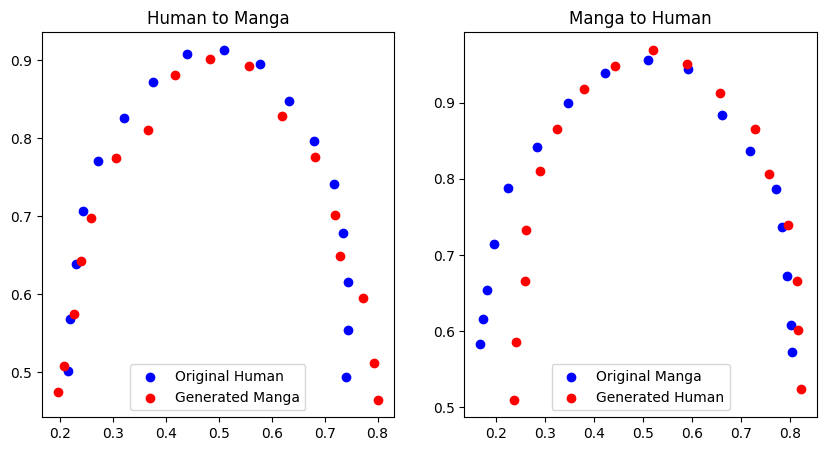

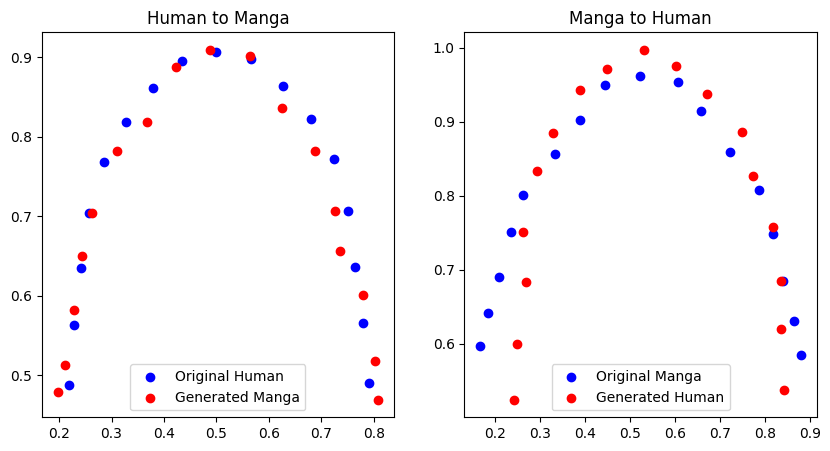

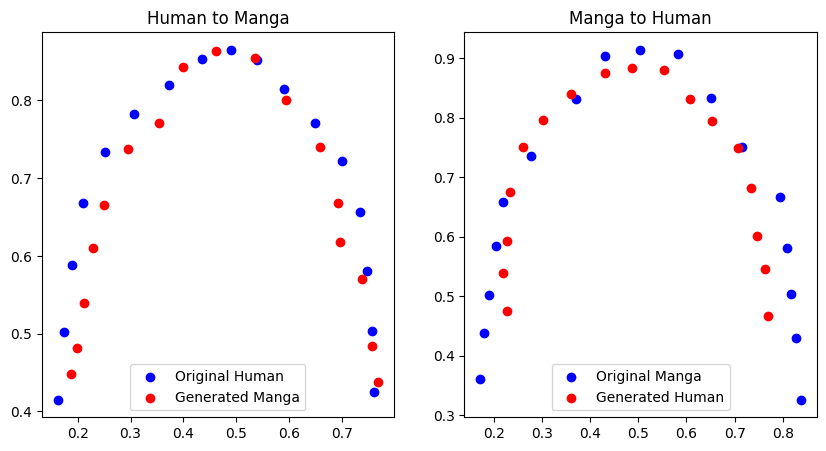

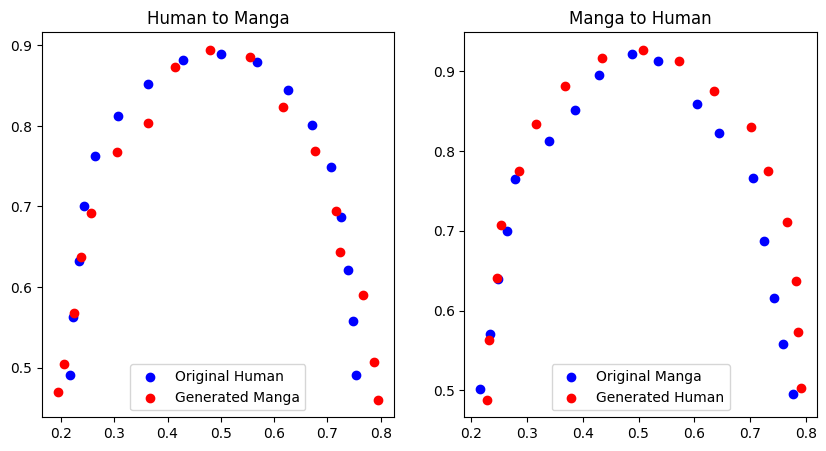

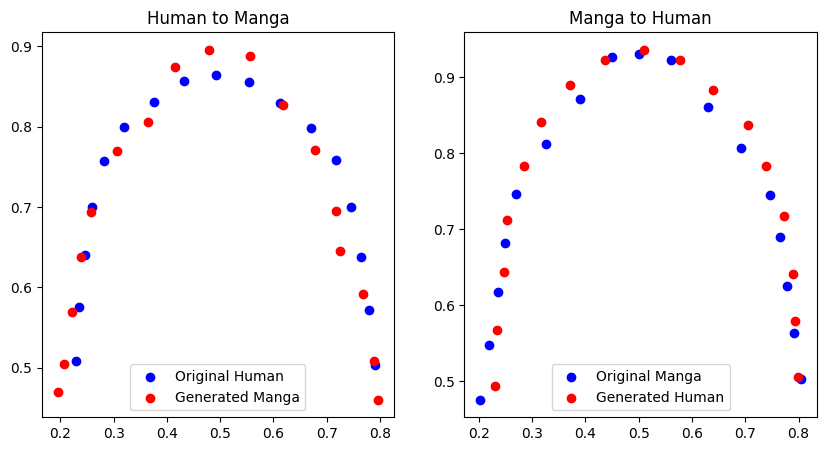

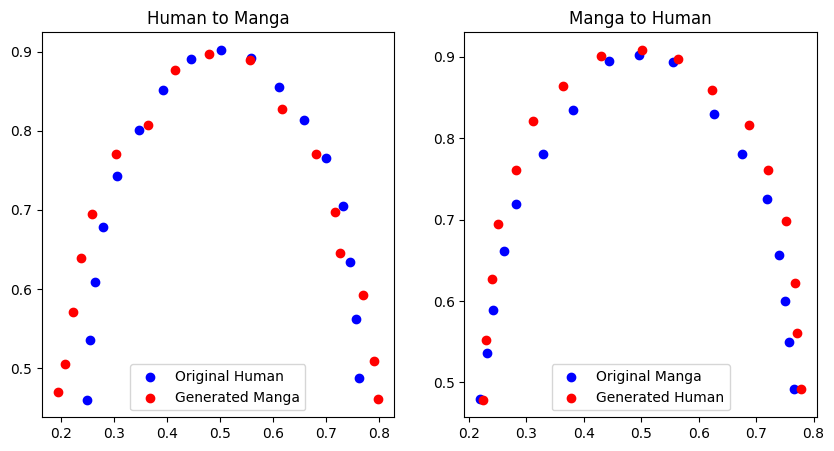

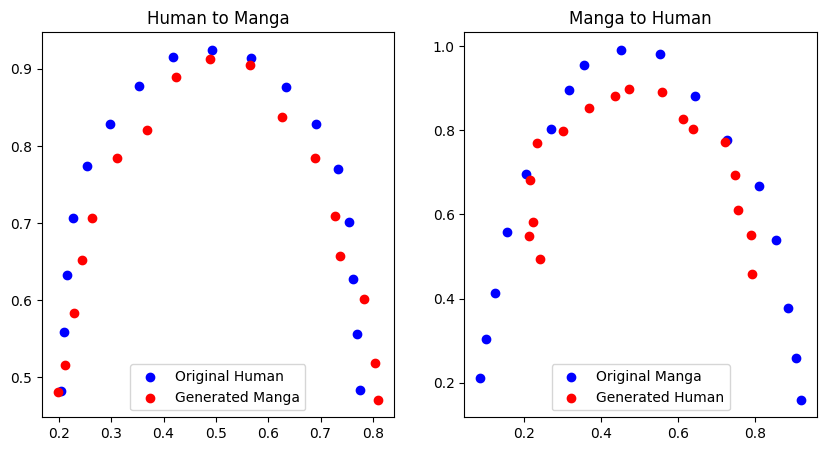

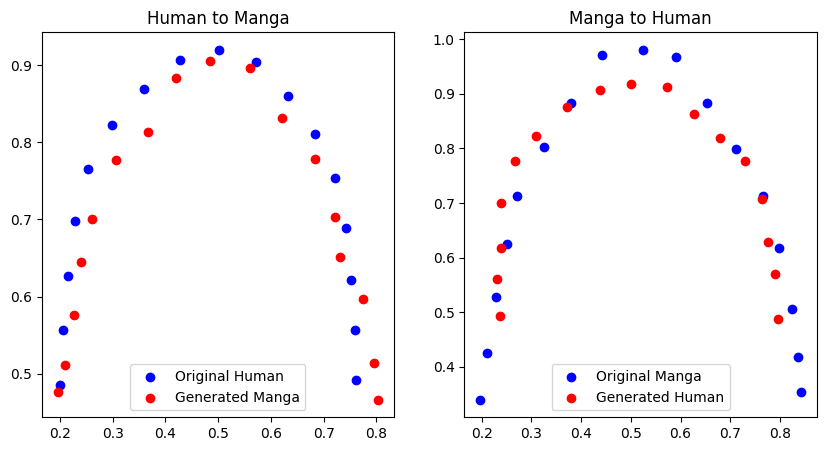

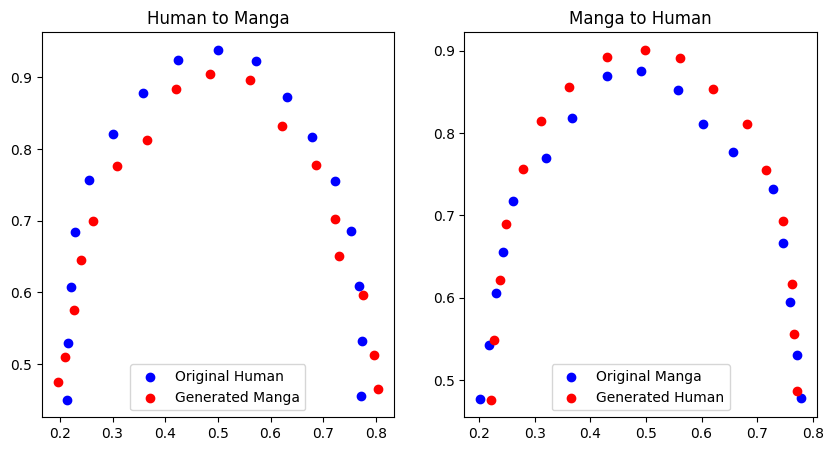

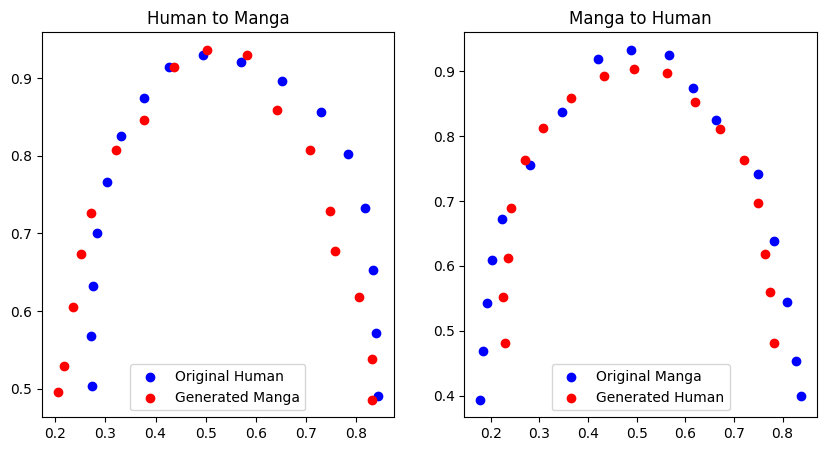

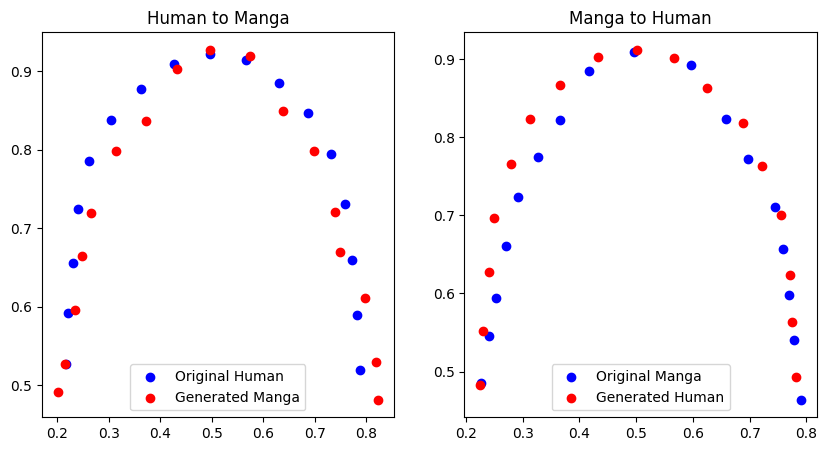

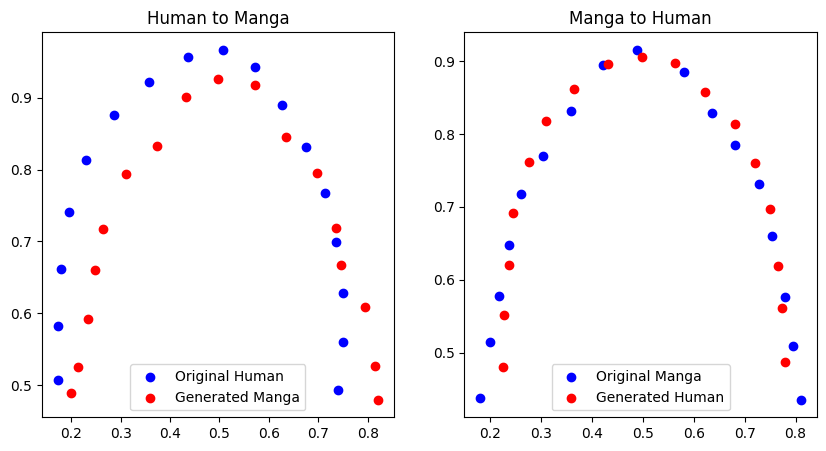

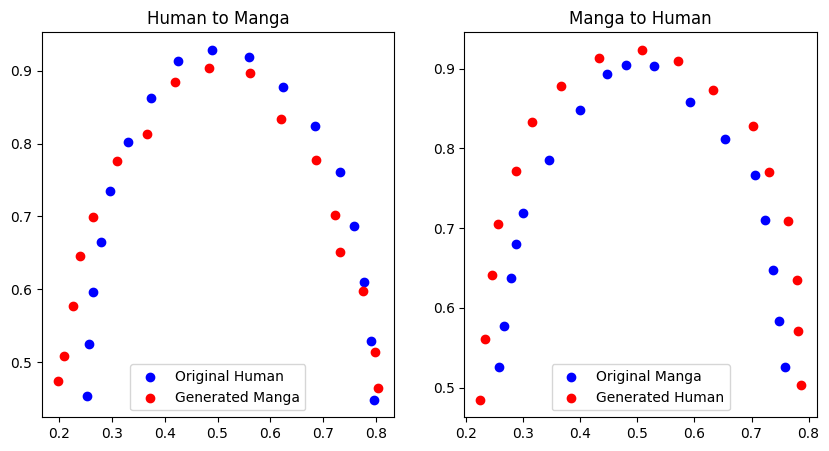

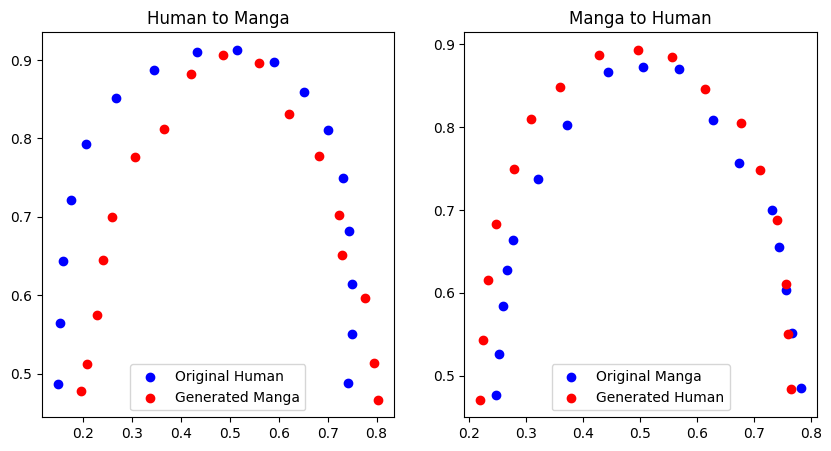

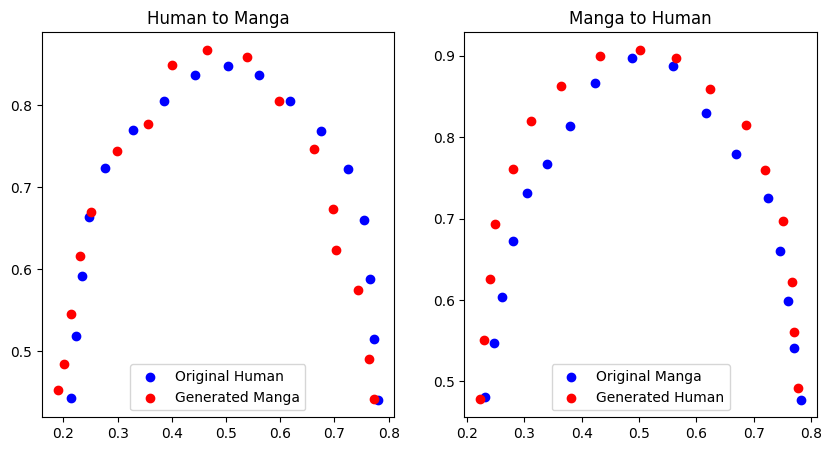

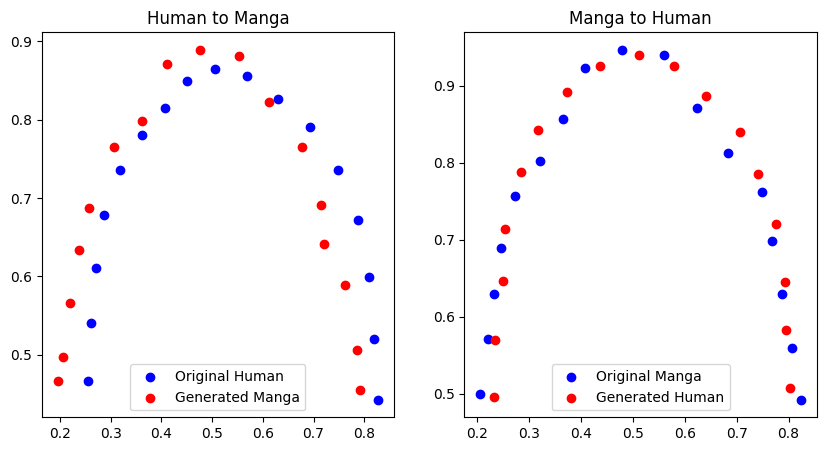

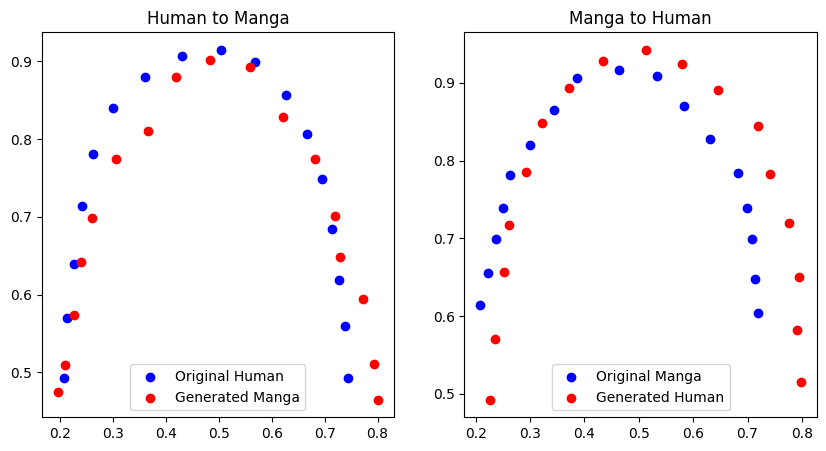

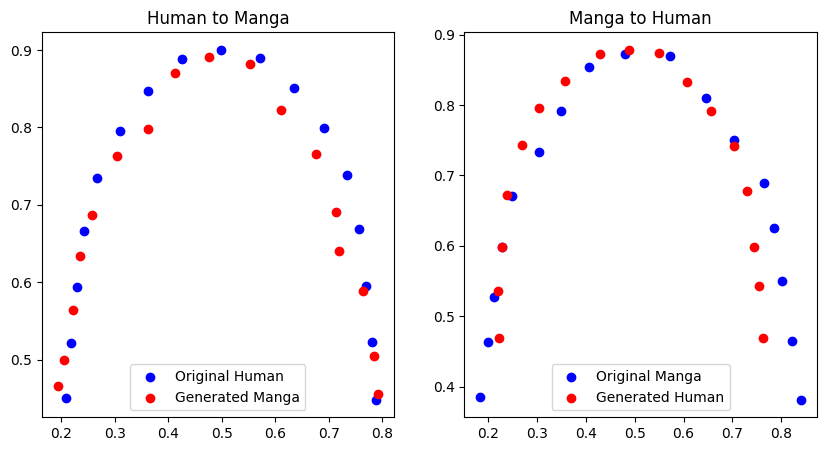

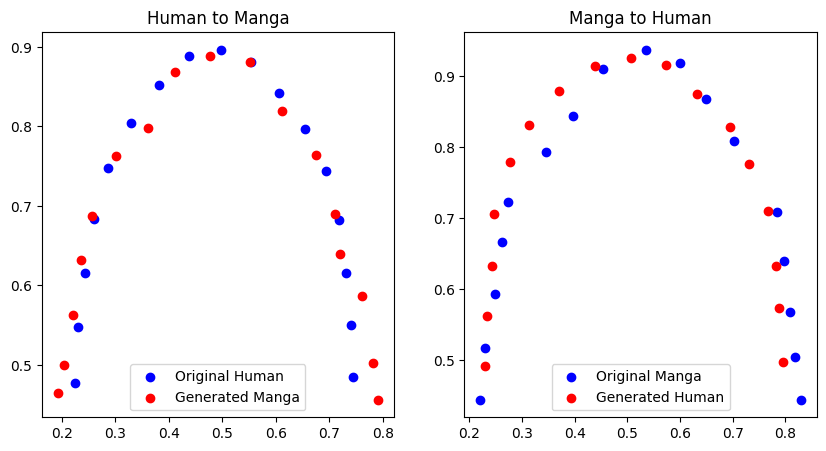

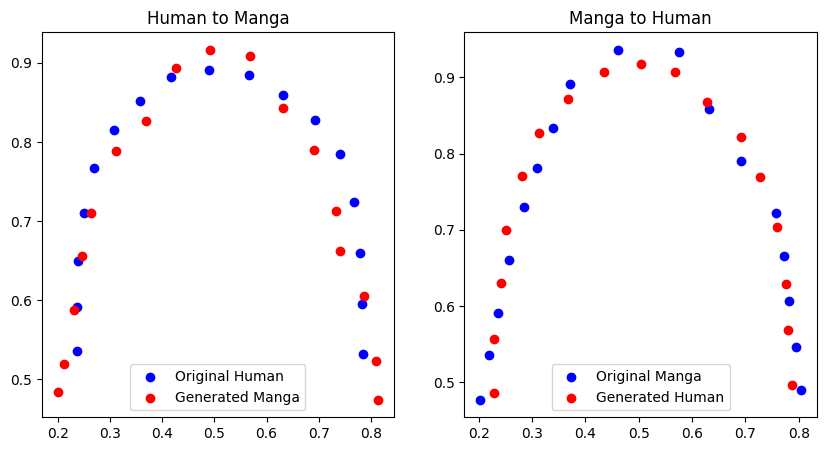

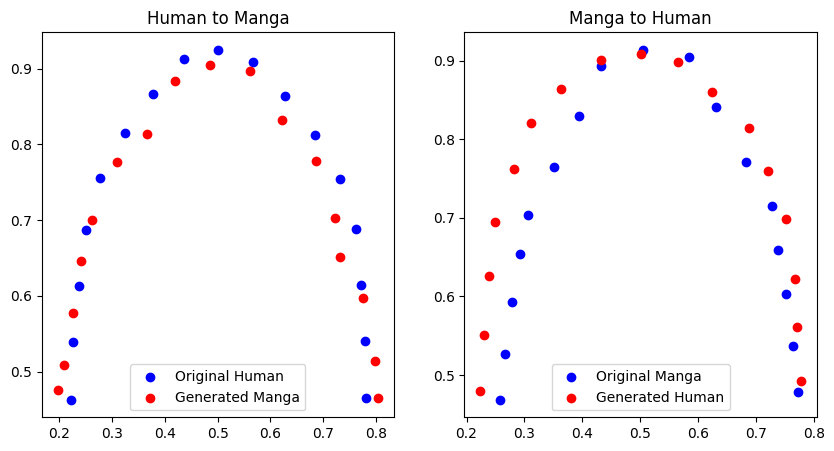

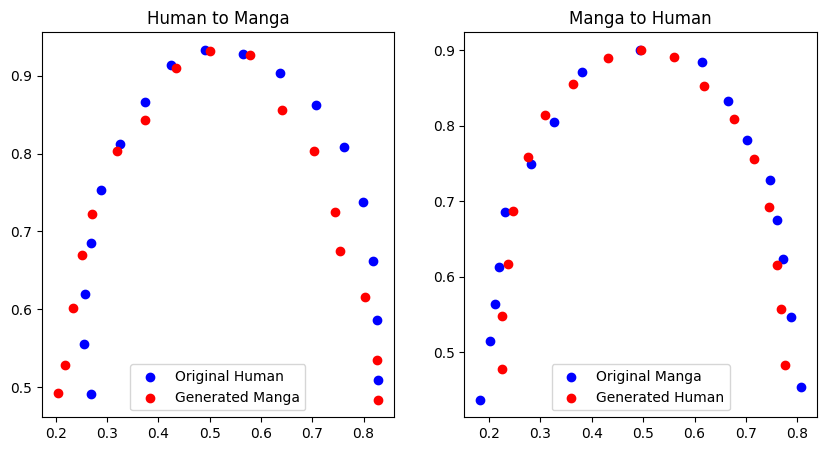

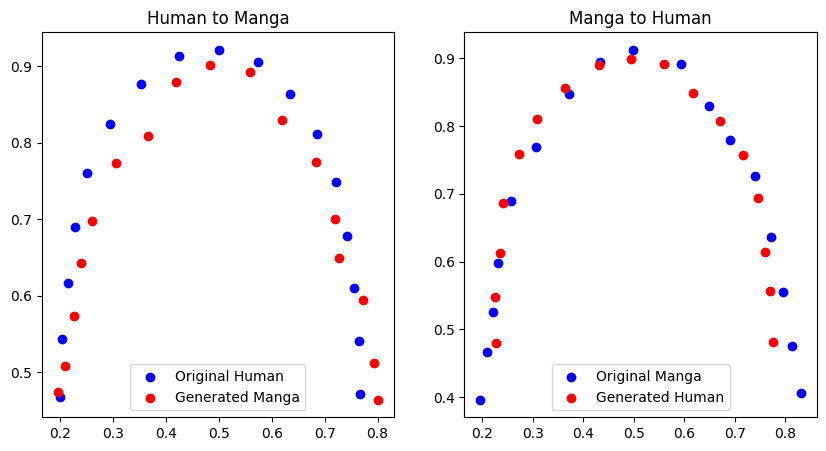

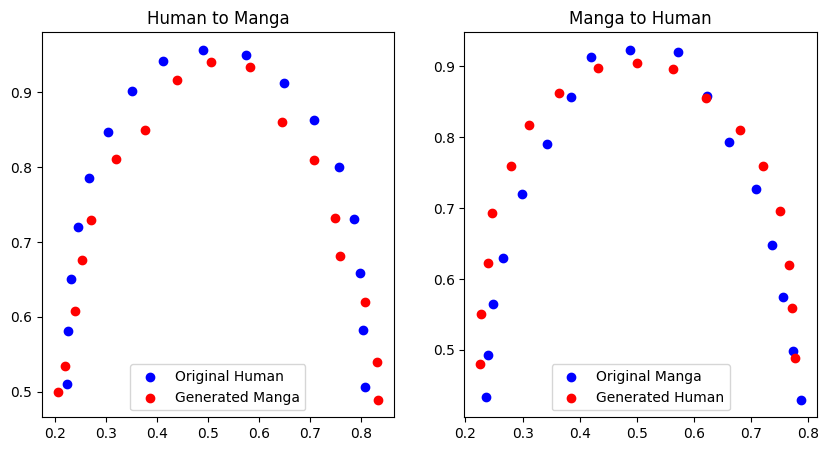

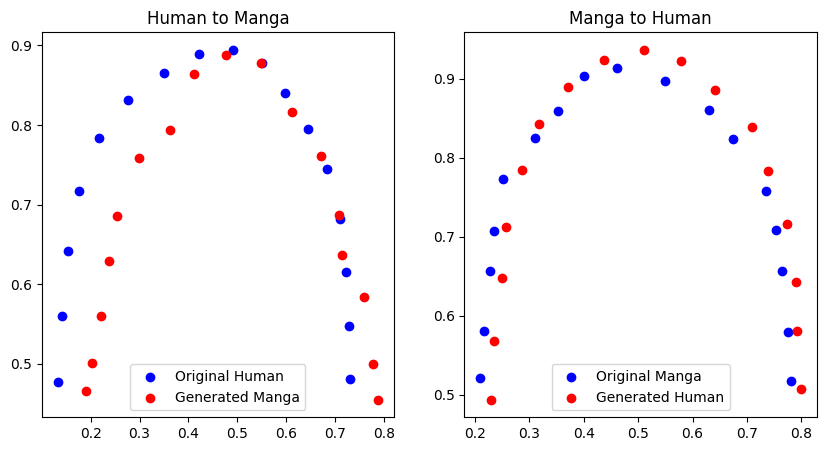

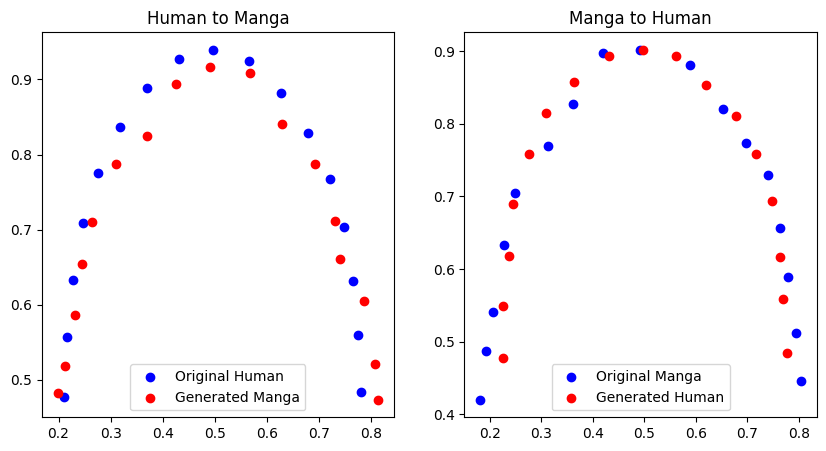

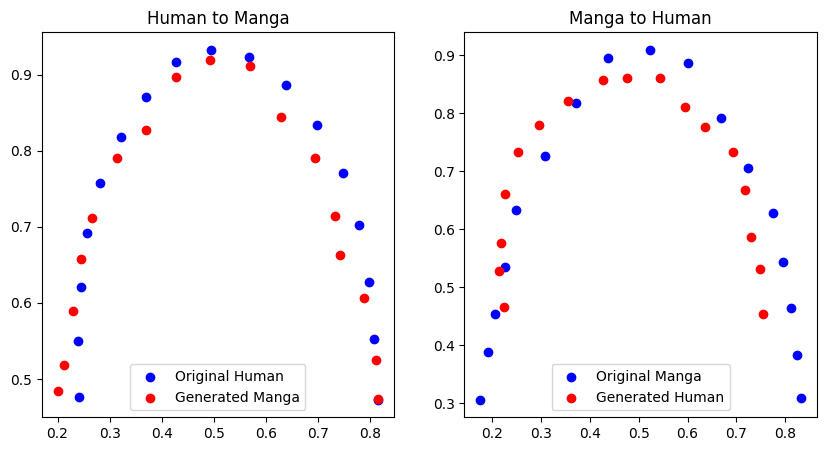

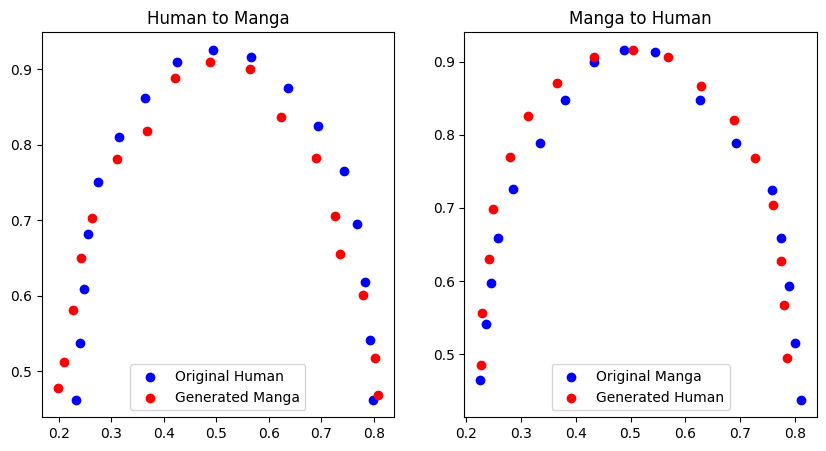

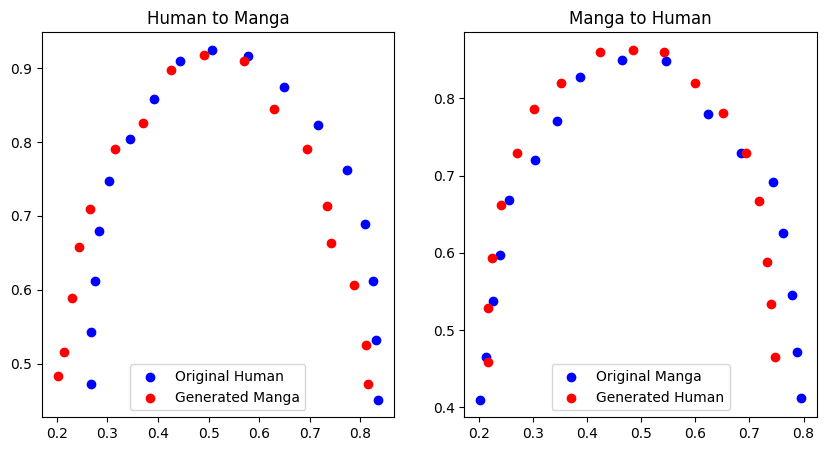

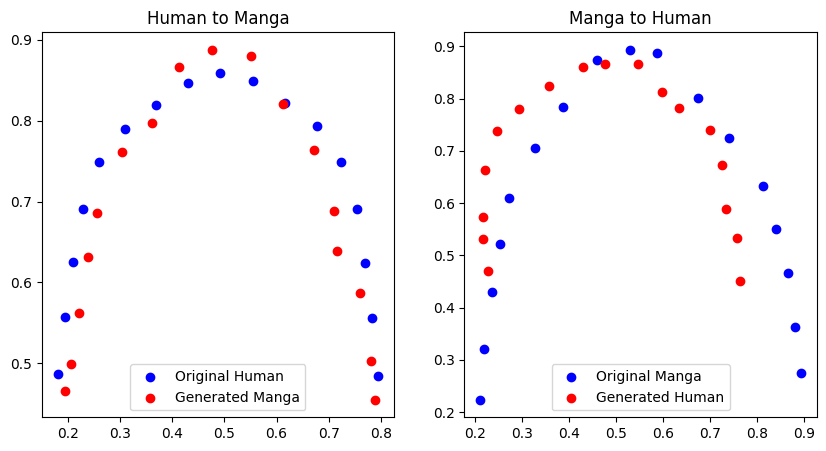

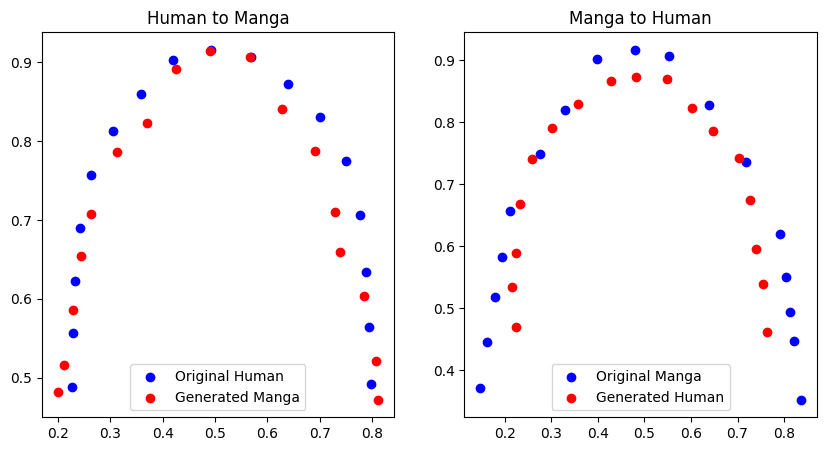

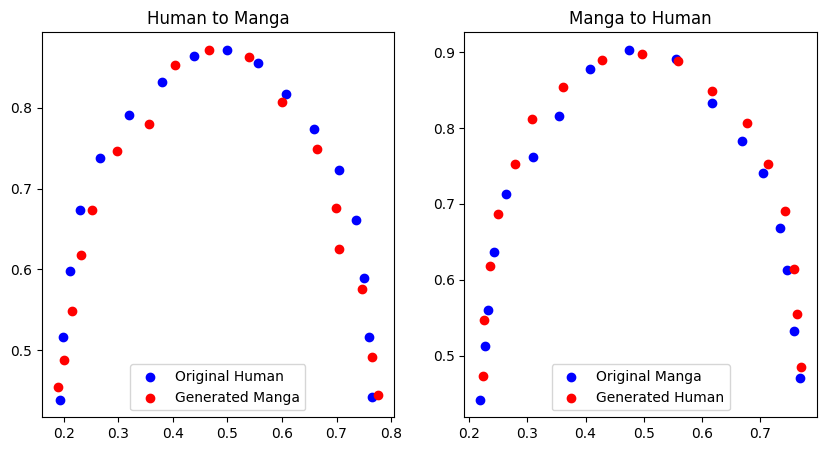

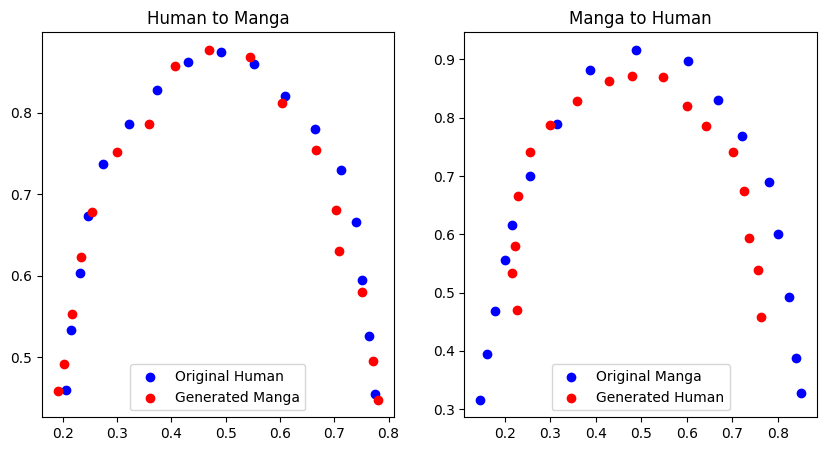

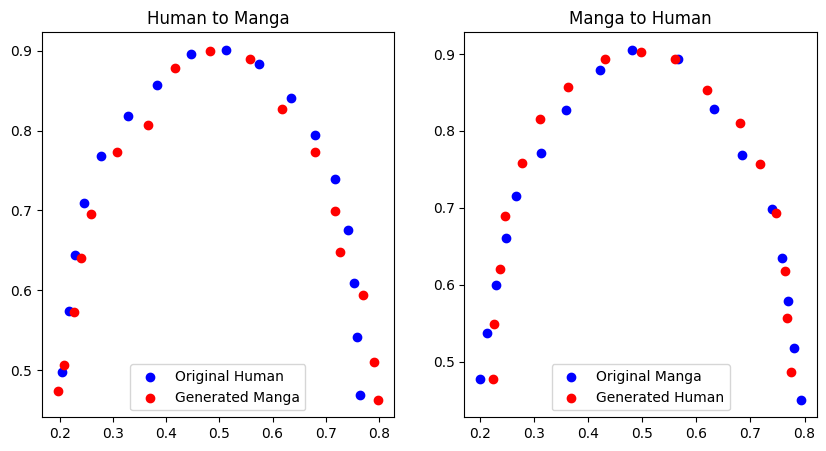

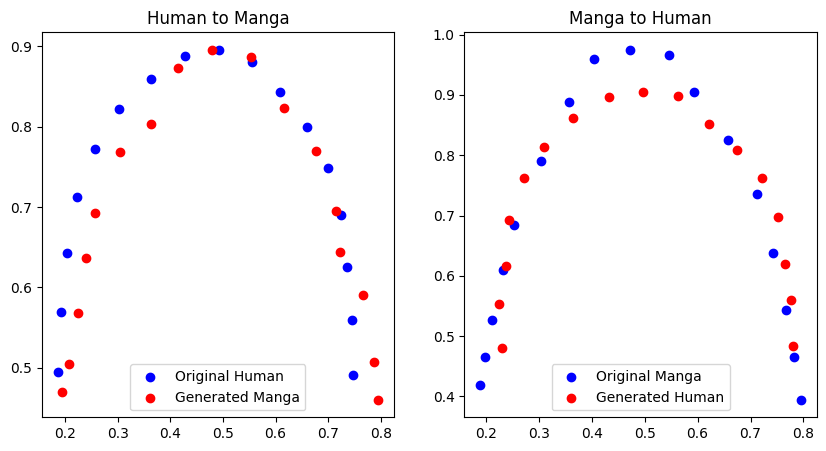

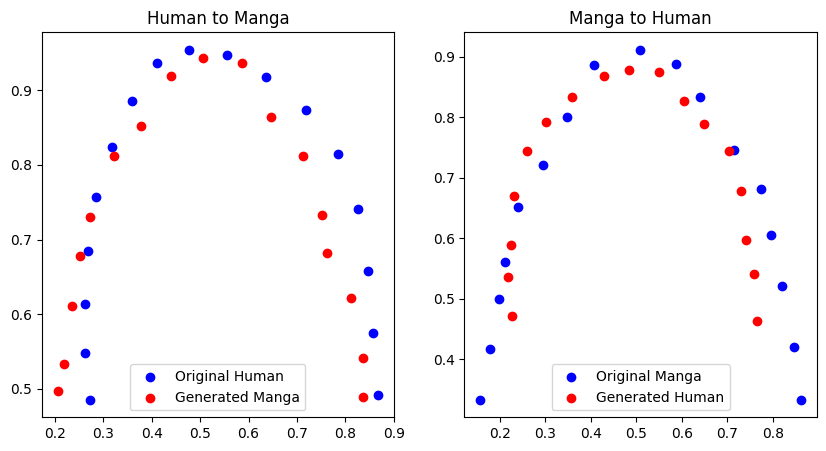

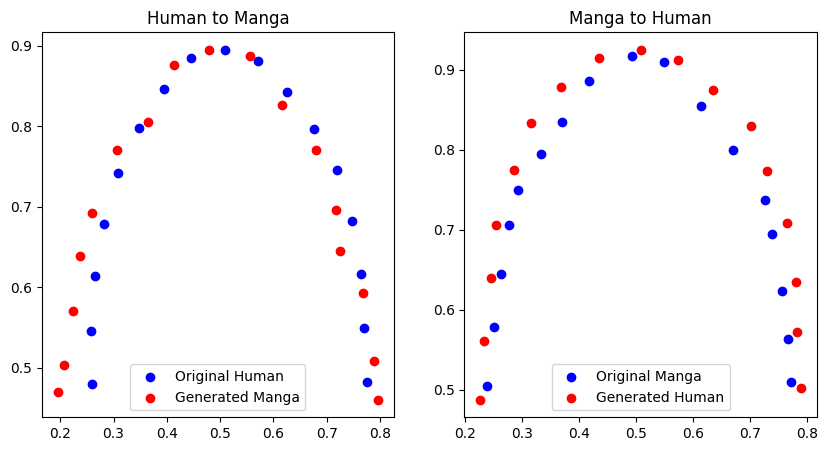

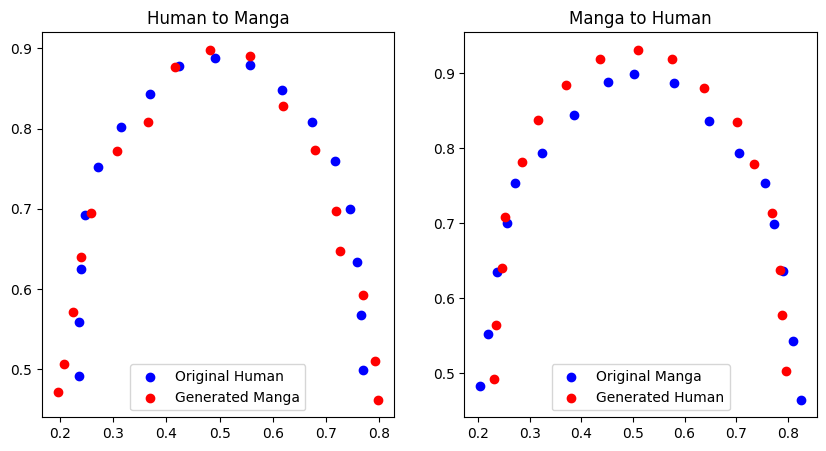

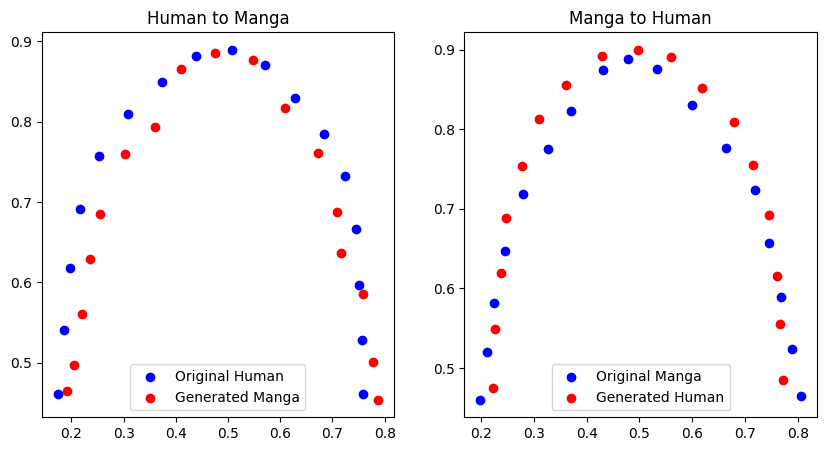

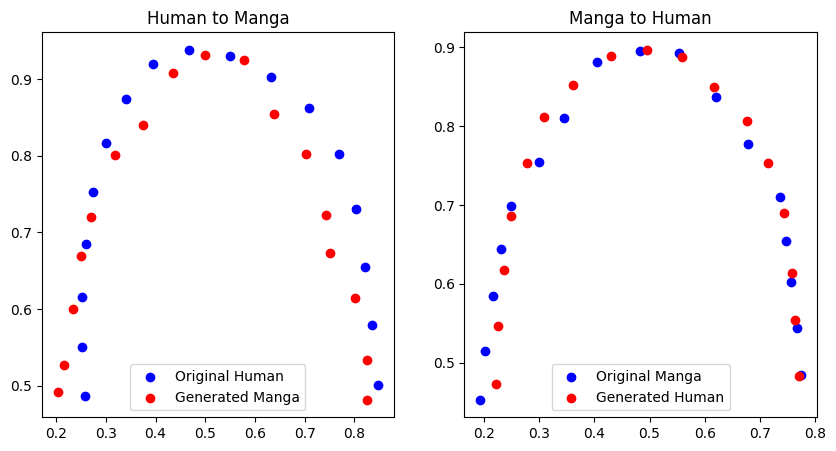

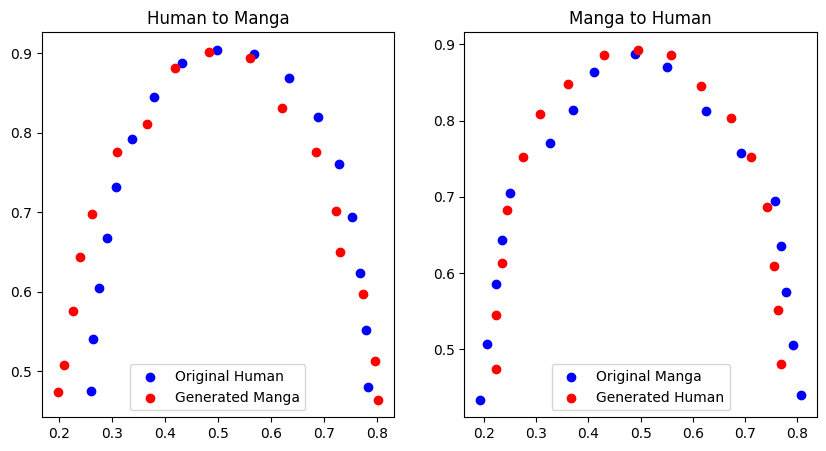

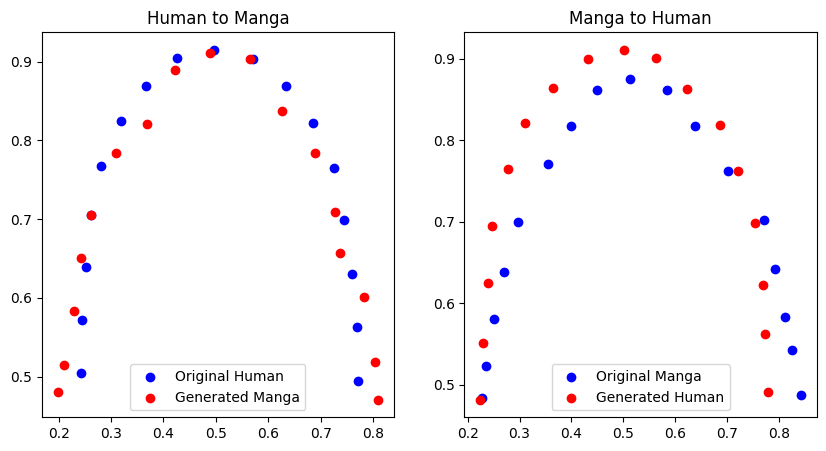

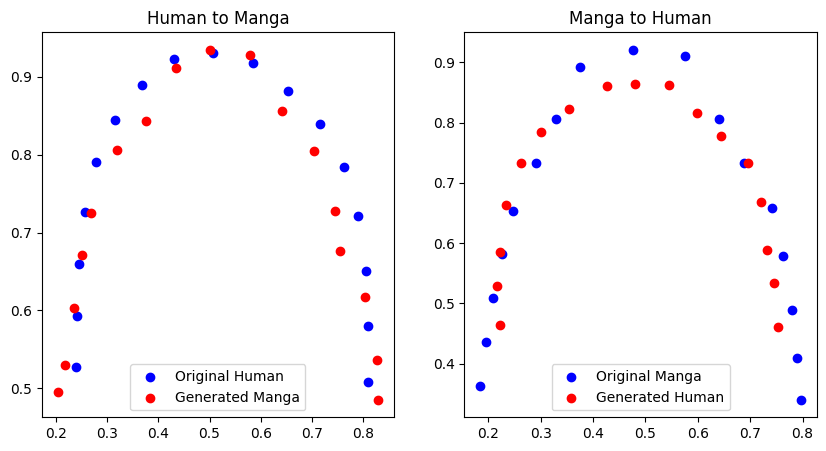

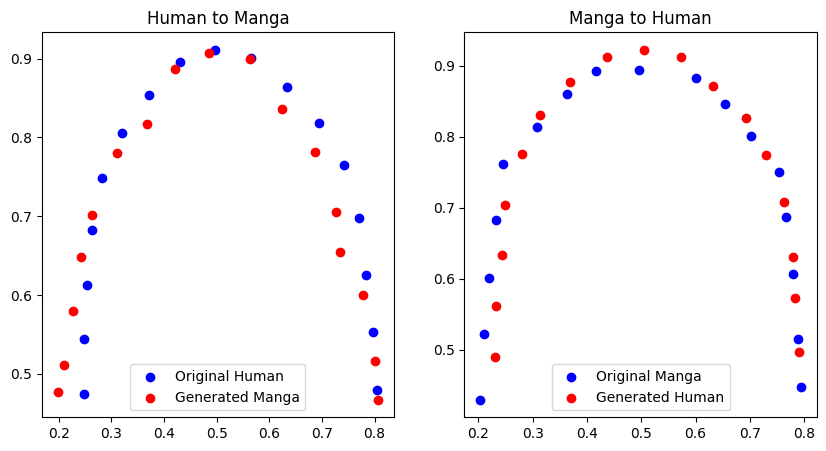

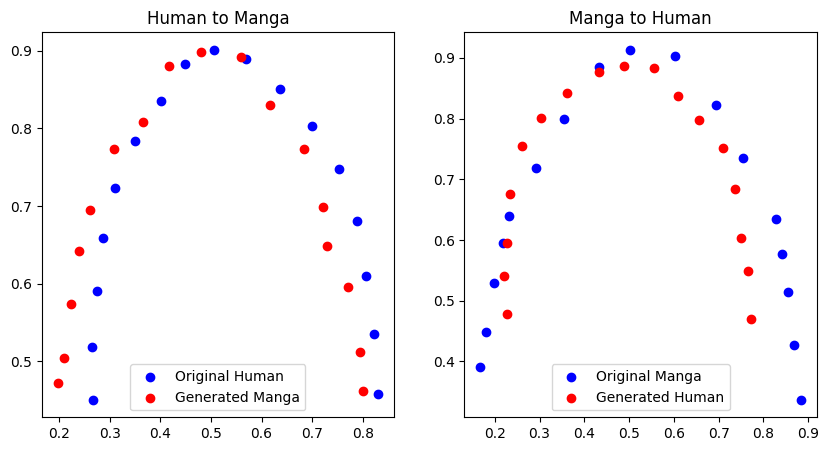

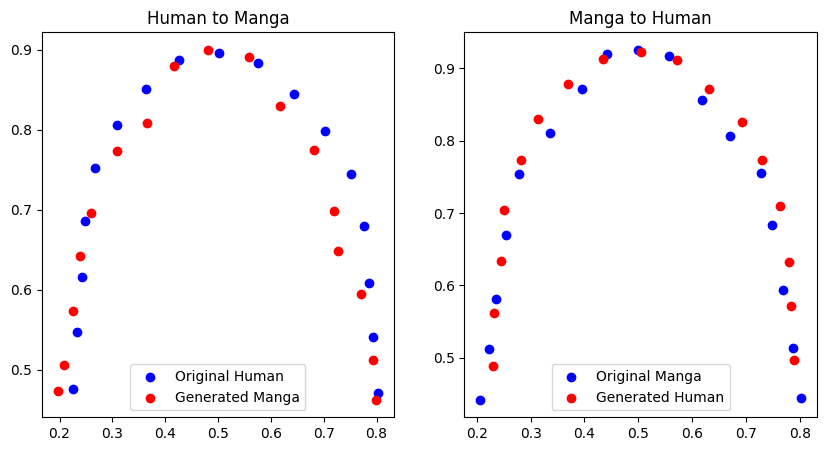

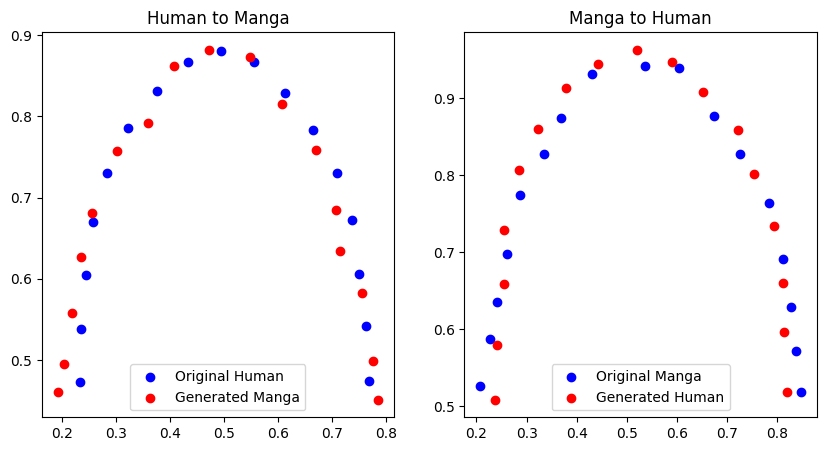

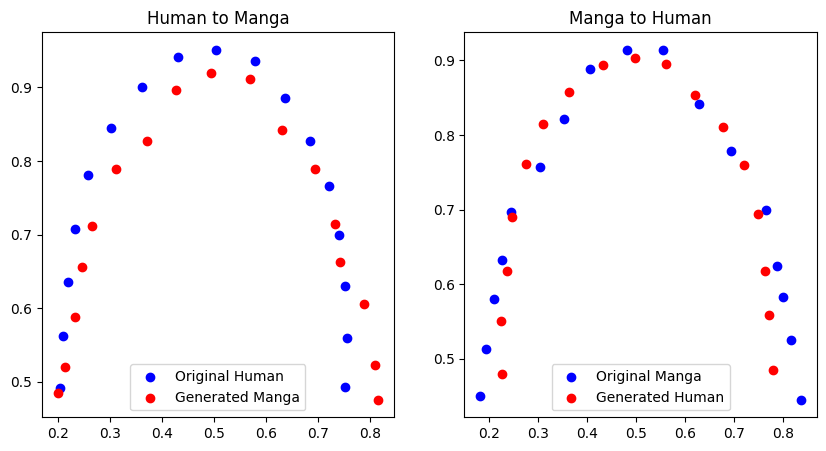

In [8]:
test_human_dataset = LandmarkDataset("human_landmarks")
test_manga_dataset = LandmarkDataset("manga_landmarks")

test_human_dataloader = DataLoader(test_human_dataset, batch_size=1, shuffle=False)
test_manga_dataloader = DataLoader(test_manga_dataset, batch_size=1, shuffle=False)

def test_model():
    G_H2M.eval()
    G_M2H.eval()

    with torch.no_grad():
        for i, (human_landmarks, manga_landmarks) in enumerate(zip(test_human_dataloader, test_manga_dataloader)):
            human_landmarks = human_landmarks
            manga_landmarks = manga_landmarks

            # Generate manga landmarks from human landmarks
            generated_manga_landmarks = G_H2M(human_landmarks)

            # Generate human landmarks from manga landmarks
            generated_human_landmarks = G_M2H(manga_landmarks)

            # Plot original and generated landmarks for comparison
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.scatter(human_landmarks[0][::2], human_landmarks[0][1::2], c='blue', label='Original Human')
            plt.scatter(generated_manga_landmarks[0][::2], generated_manga_landmarks[0][1::2], c='red', label='Generated Manga')
            plt.title('Human to Manga')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.scatter(manga_landmarks[0][::2], manga_landmarks[0][1::2], c='blue', label='Original Manga')
            plt.scatter(generated_human_landmarks[0][::2], generated_human_landmarks[0][1::2], c='red', label='Generated Human')
            plt.title('Manga to Human')
            plt.legend()

            plt.show()

# Load the models
G_H2M.load_state_dict(torch.load('G_H2M.pth'))
G_M2H.load_state_dict(torch.load('G_M2H.pth'))

# Test the model
test_model()
